'SNS_analysis_total' 폴더가 이미 존재합니다.
데이터 로드 성공!
전처리 완료.
바이그램 분석 시작...


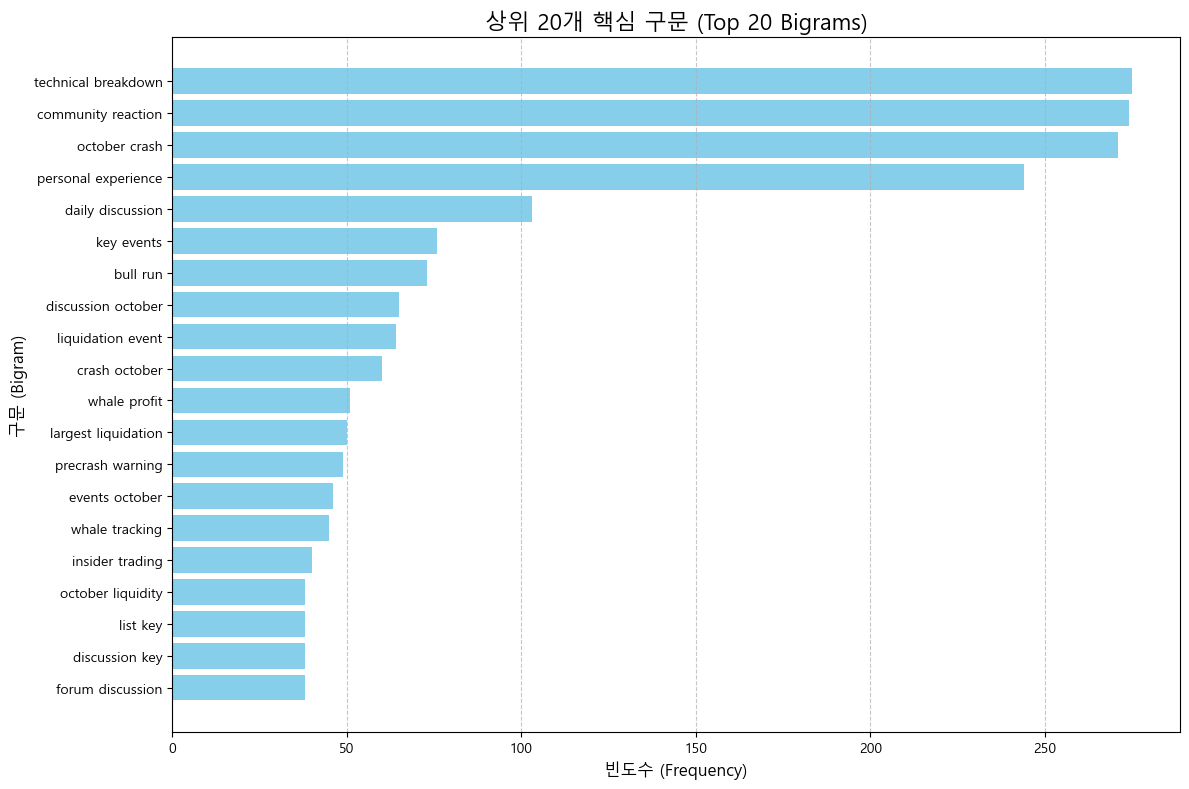

토픽 모델링 시작...


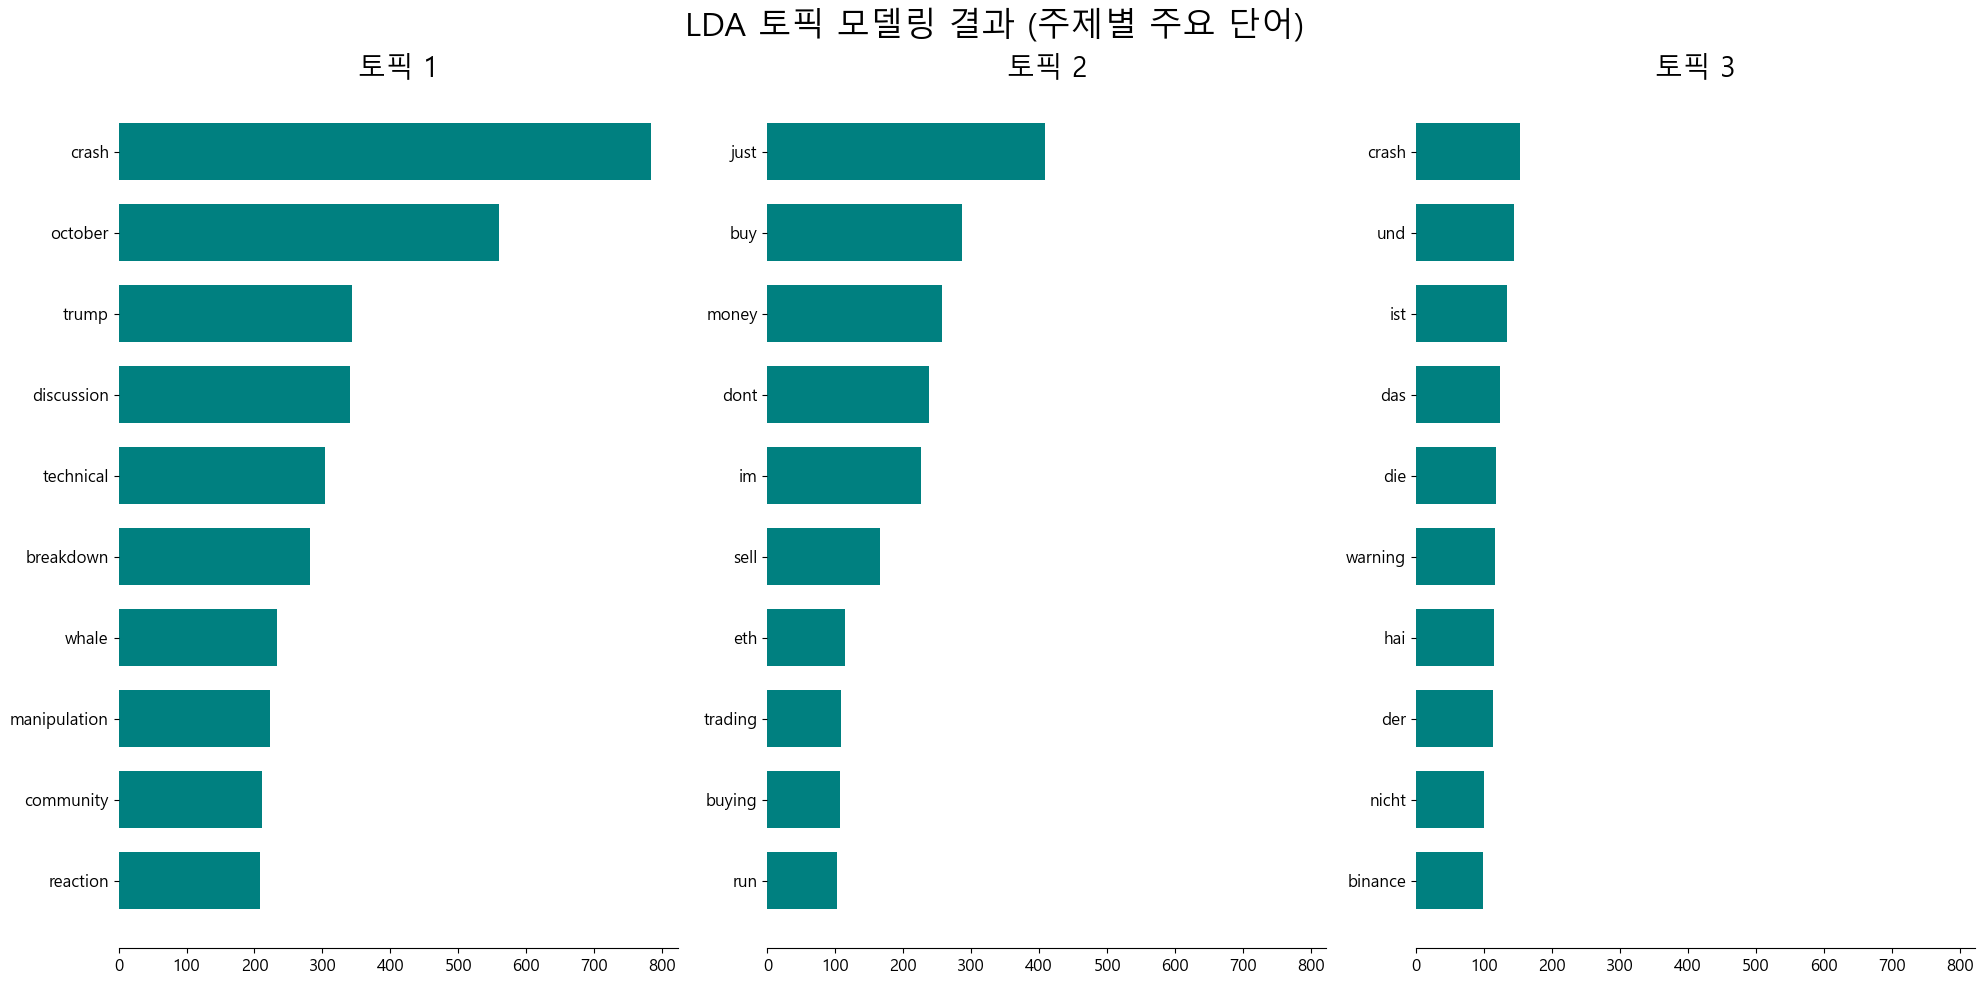

모든 분석이 완료되었습니다


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import platform
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob # 감성 분석용 라이브러리
import warnings


# 결과 저장 폴더 생성
output_dir = 'SNS_analysis_total'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"'{output_dir}' 폴더를 생성했습니다.")
else:
    print(f"'{output_dir}' 폴더가 이미 존재합니다.")

# 한글 폰트 설정 (OS 자동 감지)
system_name = platform.system()
if system_name == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif system_name == 'Darwin': # Mac
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic') # Linux 등

plt.rc('axes', unicode_minus=False) # 마이너스 기호 깨짐 방지

# 데이터 로드
try:
    df = pd.read_csv('FINAL_SNS_YOUTUBE.csv')
    print("데이터 로드 성공!")
except FileNotFoundError:
    print("오류: 'FINAL_SNS_YOUTUBE.csv' 파일을 찾을 수 없습니다.")
    # 임시 데이터 생성을 막고 에러 처리

# ==========================================
# 2. 전처리 (Preprocessing)
# ==========================================

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    # 소문자 변환
    text = text.lower()
    # URL 제거
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # 특수문자 및 숫자 제거
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # 불필요한 공백 제거
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 전처리 적용
df['clean_content'] = df['content'].apply(preprocess_text)

# 빈 내용 제거
df_clean = df[df['clean_content'] != '']

# 불용어 설정 (영어 불용어 + 독일어 및 분석 무의미 단어 추가)
# sklearn의 기본 불용어 목록을 가져와서 확장
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
custom_stop_words = list(ENGLISH_STOP_WORDS)
custom_stop_words.extend([
    'warpup', 'wrapup', 'wrap',
    'news', 'report', 'reports', 'reported', 'reporting',
    'analysis', 'analyst', 'analysts',
    'say', 'says', 'said', 'saying', 'according',
    'amid', 'update', 'updates', 'latest',
    'today', 'yesterday', 'tomorrow',
    'time', 'year', 'years', 'week', 'weeks', 'day', 'days', 'month', 'months',
    'people', 'investor', 'investors', 'trader', 'traders',
    'good', 'bad', 'new', 'old', 'great',
    'much', 'many', 'high', 'low', 'big', 'small',
    'million', 'billion',
    'hit', 'hits', 'rise', 'rises', 'rising', 'rose',
    'fall', 'falls', 'falling', 'fell',
    'surge', 'surges', 'surging',
    'drop', 'drops', 'dropping',
    'bitcoin', 'btc', 'crypto', 'cryptocurrency',
    'price', 'prices', 'pricing',
    'market', 'markets',
    'stock', 'stocks',
    'ethereum', 'xrp', 'gold',
    'etf', 'etfs',
    'mining', 'miner',
    'record', 'rally',
    'video', 'channel', 'subscribe', 'link',
    'thank', 'thanks',
    'got', 'get', 'getting',
    'now', 'one', 'use', 'make', 'see', 'look', 'watch',
    'like', 'know', 'think', 'going', 'would', 'could', 'should'
])

print("전처리 완료.")

# ==========================================
# 3. 바이그램 (Bigram) 분석 및 시각화
# ==========================================
print("바이그램 분석 시작...")

# Bigram 벡터화
vectorizer_bi = CountVectorizer(stop_words=custom_stop_words, ngram_range=(2, 2), max_features=20)
X_bi = vectorizer_bi.fit_transform(df_clean['clean_content'])

# 빈도 계산
bi_counts = X_bi.toarray().sum(axis=0)
bi_names = vectorizer_bi.get_feature_names_out()
bi_df = pd.DataFrame({'bigram': bi_names, 'count': bi_counts}).sort_values(by='count', ascending=True)

# 시각화
plt.figure(figsize=(12, 8))
plt.barh(bi_df['bigram'], bi_df['count'], color='skyblue')
plt.title('상위 20개 핵심 구문 (Top 20 Bigrams)', fontsize=16)
plt.xlabel('빈도수 (Frequency)', fontsize=12)
plt.ylabel('구문 (Bigram)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'bigram_analysis.png'))
plt.show()

# ==========================================
# 4. LDA 토픽 모델링 (Topic Modeling)
# ==========================================
print("토픽 모델링 시작...")

# LDA용 벡터화 (단어 출현 빈도 기반)
vectorizer_lda = CountVectorizer(stop_words=custom_stop_words, max_features=1000, max_df=0.9, min_df=5)
X_lda = vectorizer_lda.fit_transform(df_clean['clean_content'])

# LDA 모델 학습 (3개 토픽으로 설정)
lda_model = LatentDirichletAllocation(n_components=3, random_state=42)
lda_model.fit(X_lda)

# 토픽별 주요 단어 추출 함수
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 3, figsize=(20, 10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7, color='teal')
        ax.set_title(f'토픽 {topic_idx + 1}', fontdict={'fontsize': 20})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=24)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'lda_topics.png'))
    plt.show()

tf_feature_names = vectorizer_lda.get_feature_names_out()
plot_top_words(lda_model, tf_feature_names, 10, 'LDA 토픽 모델링 결과 (주제별 주요 단어)')

print("모든 분석이 완료되었습니다")

데이터 로딩 중...
분석 대상 기간: 2025-10-01 ~ 2025-10-31
추출된 데이터 수: 5280건
히트맵 생성 중...
저장 완료: SNS_analysis_total\keyword_heatmap_contrast.png


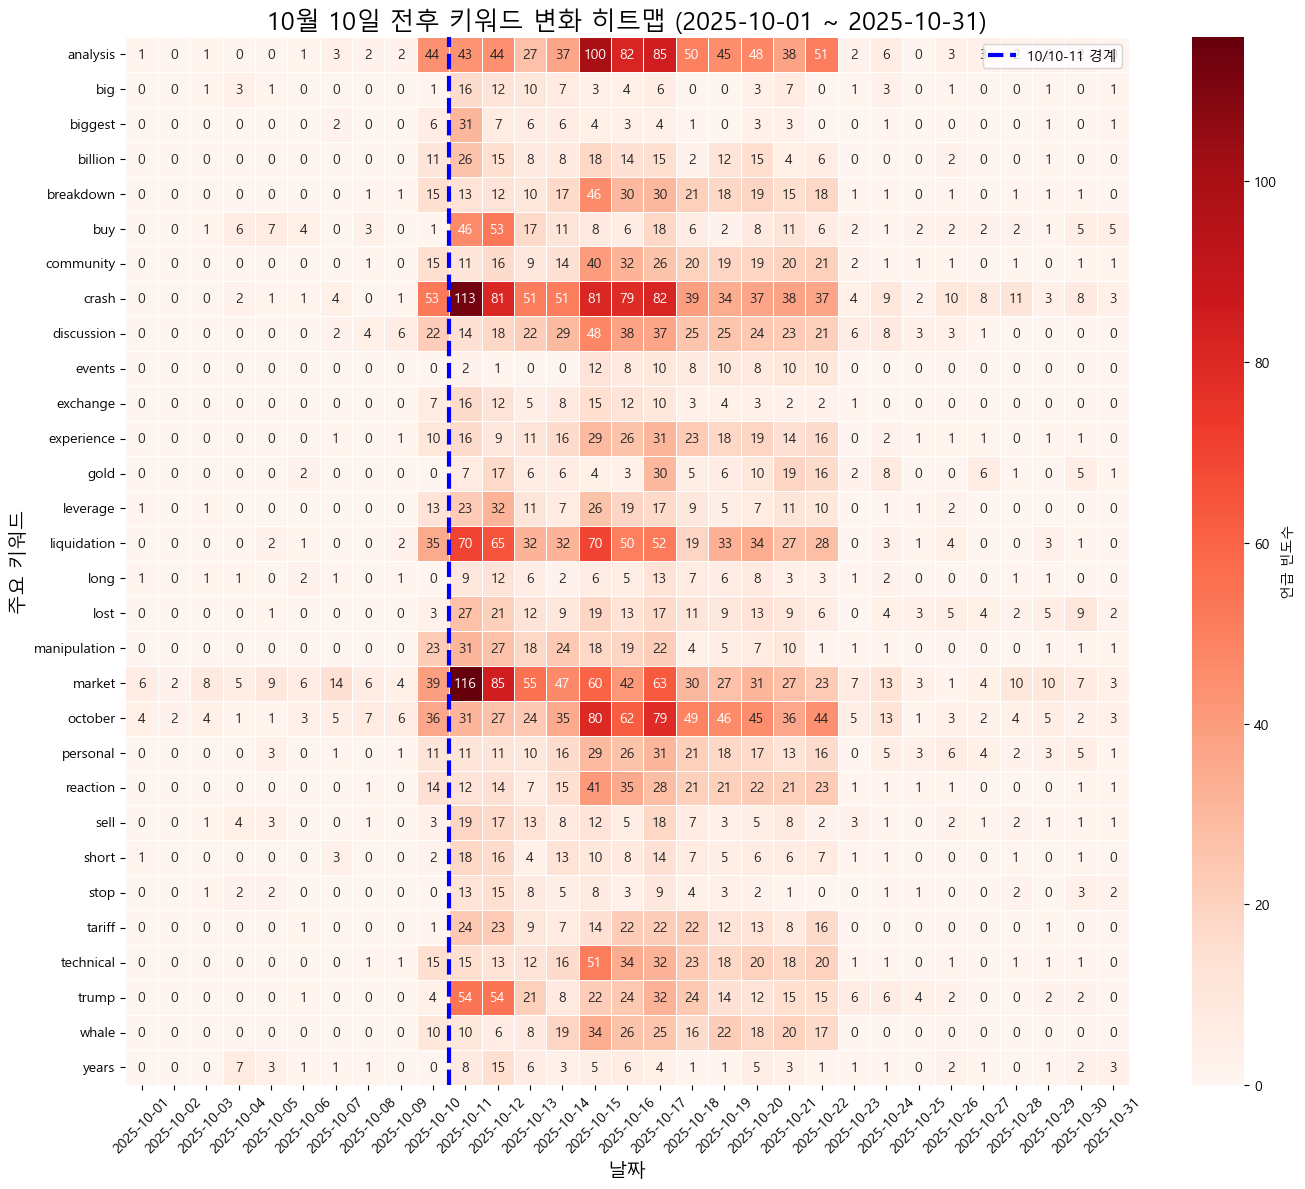

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import font_manager, rc
import platform

# ---------------------------------------------------------
# 1. 환경 설정 (한글 폰트 & 저장 폴더)
# ---------------------------------------------------------
def set_korean_font():
    system_name = platform.system()
    if system_name == 'Windows':
        rc('font', family='Malgun Gothic')
    elif system_name == 'Darwin': # Mac
        rc('font', family='AppleGothic')
    else:
        # Linux/Colab 등
        rc('font', family='NanumGothic')
    plt.rcParams['axes.unicode_minus'] = False

set_korean_font()

# 결과 저장 폴더
output_dir = 'SNS_analysis_total'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# ---------------------------------------------------------
# 2. 데이터 로드 및 전처리
# ---------------------------------------------------------
print("데이터 로딩 중...")
df = pd.read_csv('FINAL_SNS_YOUTUBE.csv')

# 날짜 변환 (Int -> Datetime)
df['date_dt'] = pd.to_datetime(df['date'], format='%Y%m%d')

# ** 핵심: 10월 10일 전후 데이터만 필터링 (10월 1일 ~ 10월 31일) **
start_date = '2025-10-01'
end_date = '2025-10-31'
mask = (df['date_dt'] >= start_date) & (df['date_dt'] <= end_date)
df_focus = df.loc[mask].copy()

print(f"분석 대상 기간: {start_date} ~ {end_date}")
print(f"추출된 데이터 수: {len(df_focus)}건")

# 텍스트 정제 함수
def clean_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'http\S+', '', text) # URL 제거
    text = re.sub(r'[^\w\s]', '', text) # 특수문자 제거
    text = re.sub(r'\d+', '', text) # 숫자 제거
    text = re.sub(r'\btariffs\b', 'tariff', text) # tariffs => tariff
    text = re.sub(r'\bloss\b', 'lost', text) # loss=> loss
    text = re.sub(r'\bliquidated\b', 'liquidation', text) # liquidated = liquidation
    text = re.sub(r'\bliquidity\b', 'liquidation', text) # liquidity = liquidation
    text = re.sub(r'\bliquidations\b', 'liquidation', text) # liquidations = liquidation
    
    return text.strip()

df_focus['clean_content'] = df_focus['content'].apply(clean_text)

# 불용어 설정 (기존 + 분석에 방해되는 일반적인 단어 추가)
stop_words = list(CountVectorizer(stop_words='english').get_stop_words())
add_stops = ['und', 'die', 'der', 'ist', 'das', 'video', 'youtube', 'just',
             'like', 'dont', 'im', 'know', 'people', 'time', 'think', 'warpup',
             'hai', 'going', 'grokr', 'grokl', 'got', 'thanks', 'bitcoin',
             'moeney', 'sir', 'crypto', 'btc', 'binance', 'se', 'tha',
             'trading', 'xrp', 'eth', 'good', 'did', 'good', 'ke', 'trade', 'year',
             'new', 'que', 'grokc', 'great', 'real', 'best', 'money', 'news',
             'thats', 'nicht', 'day', 'daily', 'es', 'key', 'traders', 'profit',
             'price', 'right', 'run']
stop_words.extend(add_stops)

# ---------------------------------------------------------
# 3. 키워드 추출 및 매트릭스 생성
# ---------------------------------------------------------
# 해당 기간 동안 가장 많이 등장한 상위 30개 단어 추출
cv = CountVectorizer(stop_words=stop_words, max_features=30)
X = cv.fit_transform(df_focus['clean_content'])

# 날짜별로 텍스트를 합침 (Group by Date)
daily_docs = df_focus.groupby(df_focus['date_dt'].dt.strftime('%Y-%m-%d'))['clean_content'].apply(' '.join)

# 날짜별로 다시 카운트 (상위 30개 단어 기준)
# 위에서 뽑은 상위 단어(vocabulary)만 대상으로 다시 셉니다.
cv_daily = CountVectorizer(vocabulary=cv.get_feature_names_out()) 
X_daily = cv_daily.fit_transform(daily_docs)

# 히트맵용 데이터프레임 생성 (행: 키워드, 열: 날짜)
heatmap_data = pd.DataFrame(
    X_daily.toarray().T, # Transpose하여 행을 단어로
    index=cv_daily.get_feature_names_out(),
    columns=daily_docs.index
)

# ---------------------------------------------------------
# 4. 시각화 (Heatmap)
# ---------------------------------------------------------
print("히트맵 생성 중...")
plt.figure(figsize=(14, 12))

# 색상 테마: 'Reds', 'YlOrRd', 'rocket_r' 등 추천
# 10일과 11일의 경계를 잘 보여주기 위해 날짜 라벨을 강조
sns.heatmap(heatmap_data, 
            cmap='Reds',      # 붉은색 계열 (빈도 높을수록 진함)
            linewidths=.5,    # 칸 구분선
            annot=True,       # 숫자 표시 (필요 없으면 False)
            fmt='d',          # 정수 표현
            cbar_kws={'label': '언급 빈도수'})

plt.title(f'10월 10일 전후 키워드 변화 히트맵 ({start_date} ~ {end_date})', fontsize=18)
plt.xlabel('날짜', fontsize=14)
plt.ylabel('주요 키워드', fontsize=14)
plt.xticks(rotation=45)

# 10일과 11일 사이에 강조선 긋기 (시각적 구분)
# 날짜 컬럼 리스트에서 10월 5일의 인덱스를 찾아 그 오른쪽에 선을 그음
dates = list(heatmap_data.columns)
try:
    idx_target = [i for i, d in enumerate(dates) if '10-10' in d][0]
    plt.axvline(x=idx_target + 1, color='blue', linestyle='--', linewidth=3, label='10/10-11 경계')
    plt.legend()
except IndexError:
    pass # 해당 날짜가 없으면 패스

plt.tight_layout()

# 저장
save_path = os.path.join(output_dir, 'keyword_heatmap_contrast.png')
plt.savefig(save_path, dpi=300)
print(f"저장 완료: {save_path}")

plt.show()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


전처리 업그레이드 중... (Lemmatization 적용)
Bigram 워드클라우드 생성 중...


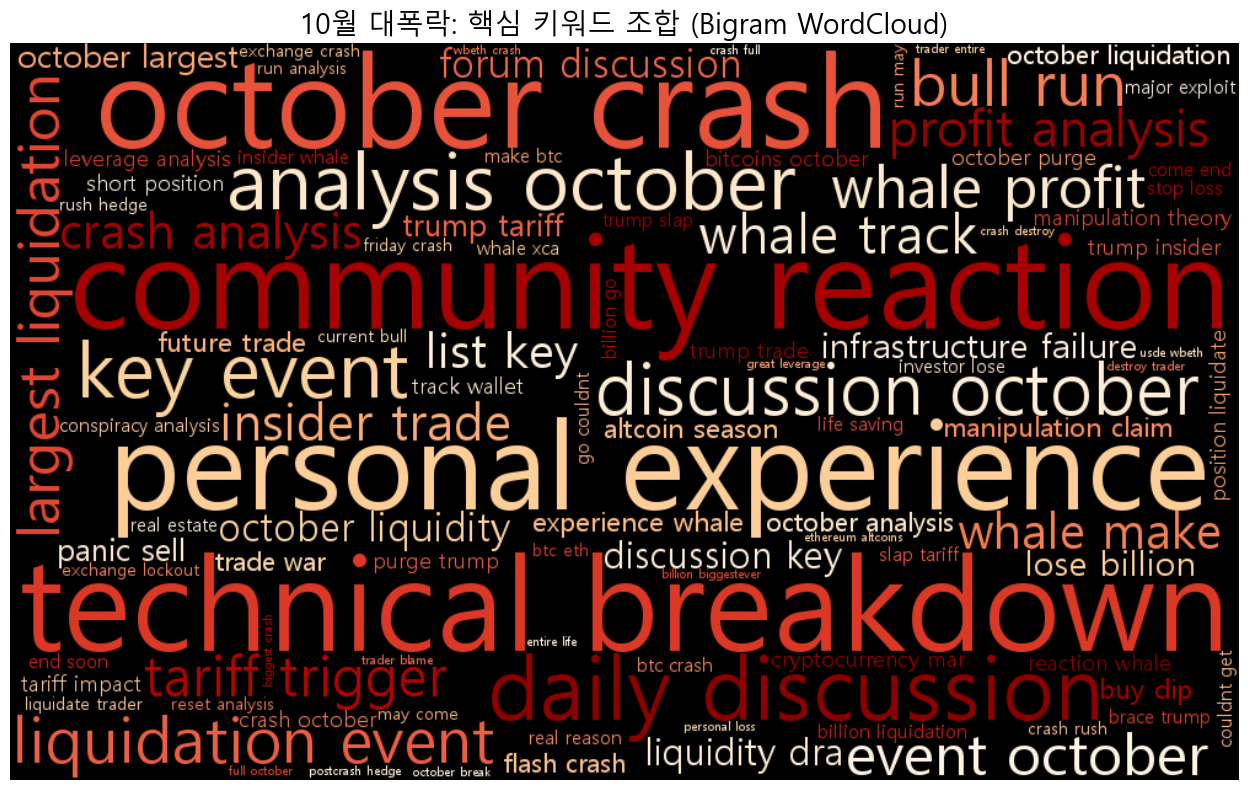

In [14]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import re

# 1. NLTK 리소스 다운로드 (최초 1회 필요)
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

# ==========================================
# 1. 강력한 전처리 함수 (Advanced Preprocessing)
# ==========================================
lemmatizer = WordNetLemmatizer()

# 불용어(Stopwords) 대폭 강화
stop_words = set(stopwords.words('english'))
# 분석에 방해되는 SNS/유튜브 상투적 용어 추가 제거
junk_words = {
    'video', 'youtube', 'subscribe', 'channel', 'link', 'click', 'bio', 'comment',
    'like', 'share', 'follow', 'guys', 'hello', 'hey', 'update', 'today', 'watching',
    'know', 'think', 'people', 'time', 'thing', 'dont', 'going', 'want', 'make',
    'year', 'market', 'price', 'bitcoin', 'crypto' # 너무 뻔한 주제어는 제외하고 싶다면 추가
}
stop_words.update(junk_words)

def advanced_clean_text(text):
    if not isinstance(text, str): return ""
    
    # 1. 소문자 변환 & URL/특수문자/숫자 제거
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    
    # 2. 단어 토큰화 (띄어쓰기 기준)
    words = text.split()
    
    # 3. 핵심: Lemmatization (뿌리 단어 찾기) & 불용어/짧은 단어 제거
    # 예: "crashed" -> "crash", "losses" -> "loss"
    meaningful_words = [
        lemmatizer.lemmatize(word, pos='v') # 동사 기준 원형 복원 (running -> run)
        for word in words 
        if word not in stop_words and len(word) > 2 # 2글자 이하 제거
    ]
    
    # 명사 기준 한번 더 (batteries -> battery)
    final_words = [lemmatizer.lemmatize(word, pos='n') for word in meaningful_words]
    
    return ' '.join(final_words)

# 데이터프레임에 적용
print("전처리 업그레이드 중... (Lemmatization 적용)")
df_focus['advanced_content'] = df_focus['content'].apply(advanced_clean_text)


# ==========================================
# 2. Bigram 워드클라우드 (단어 2개 조합)
# ==========================================
# 그냥 단어 하나보다 "Panic Sell", "Margin Call" 처럼 붙어있어야 맥락이 보입니다.

def plot_bigram_wordcloud(text_data, title):
    # Bigram(2단어) 빈도 계산
    vec = CountVectorizer(ngram_range=(2, 2), max_features=100) # 상위 100개 조합만
    X = vec.fit_transform(text_data)
    
    # 빈도 사전 만들기 {'panic sell': 50, 'market crash': 40 ...}
    counts = X.toarray().sum(axis=0)
    vocab = vec.vocabulary_
    freq_dict = {word: counts[idx] for word, idx in vocab.items()}
    
    # 워드클라우드 생성
    wc = WordCloud(
        width=1000, height=600,
        background_color='black', # 검은 배경이 더 임팩트 있음
        colormap='OrRd',          # 불타는 듯한 색상 (공포/폭락 느낌)
        font_path='C:/Windows/Fonts/malgun.ttf' if platform.system() == 'Windows' else None
    ).generate_from_frequencies(freq_dict)
    
    # 시각화
    plt.figure(figsize=(15, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20, color='black')
    plt.tight_layout()
    plt.show()

# 실행
print("Bigram 워드클라우드 생성 중...")
plot_bigram_wordcloud(df_focus['advanced_content'], "10월 대폭락: 핵심 키워드 조합 (Bigram WordCloud)")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


🧼 텍스트 세탁 중... (Lemmatization & Cleaning)
📅 기준일: 2025-10-10
⬅️ 트윗 전 텍스트 길이: 21980
➡️ 트윗 후 텍스트 길이: 341110
✨ 저장 완료: SNS_analysis_total\Trump_Tweet_Before_After_Clean.png


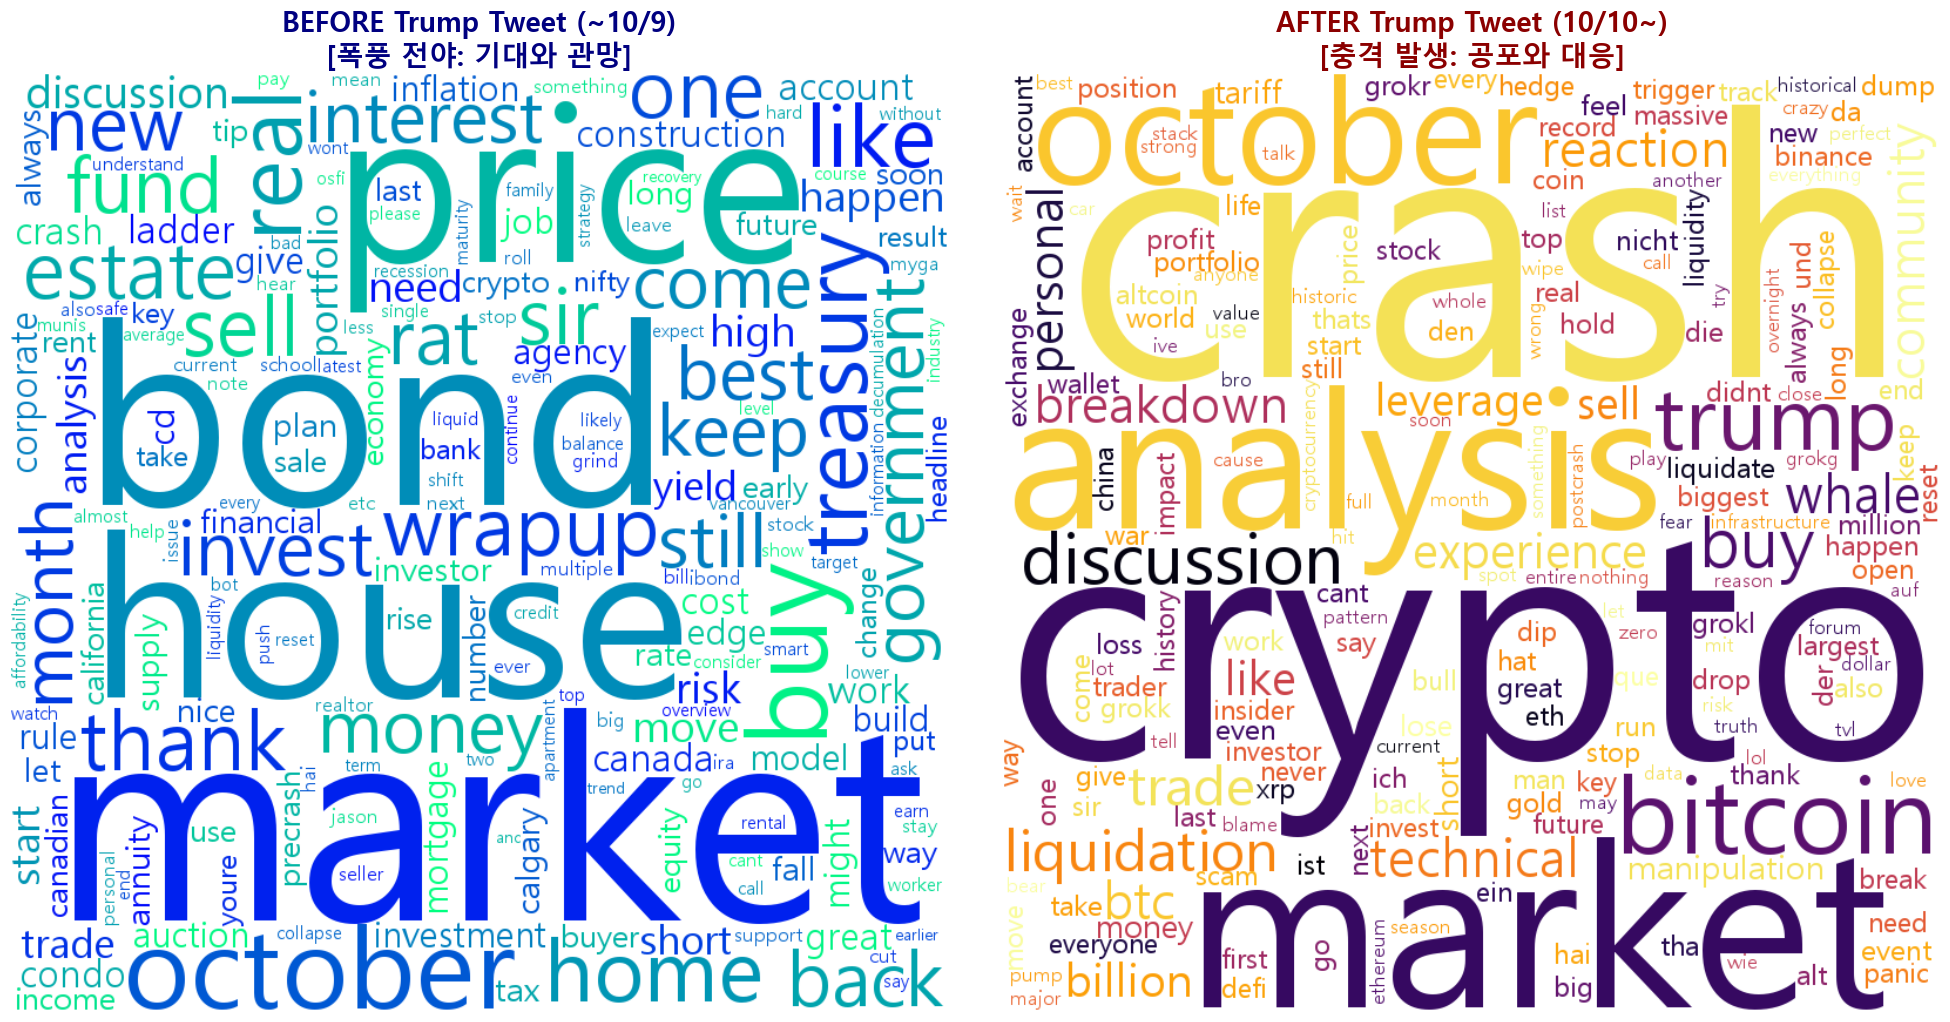

In [15]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import platform

# ==============================================================================
# 1. 강력한 전처리 설정 (Strict Cleaning Setup)
# ==============================================================================
# 리소스 다운로드 (이미 받으셨으면 생략 가능하지만 안전을 위해 넣습니다)
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

# [중요] 불용어(Stopwords) 강력하게 설정
# 기본적인 영어 불용어 + 분석에 필요 없는 '유튜브용' 잡다한 단어들 제거
stop_words = set(stopwords.words('english'))
junk_words = {
    # 유튜브/SNS 상투어 (이게 들어가면 워드클라우드가 지저분해짐)
    'video', 'youtube', 'channel', 'subscribe', 'link', 'click', 'bio', 'description',
    'comment', 'share', 'follow', 'guys', 'hello', 'hey', 'watching', 'welcome',
    'twitter', 'tweet', 'post', 'update', 'news', 'daily', 'live',
    # 의미 없는 일반 동사/명사
    'know', 'think', 'people', 'time', 'thing', 'dont', 'going', 'want', 'make',
    'get', 'got', 'see', 'look', 'good', 'really', 'much', 'many', 'would', 'could',
    'today', 'tomorrow', 'yesterday', 'year', 'week', 'day', 'right', 'well',
    # 너무 뻔해서 재미없는 단어 (필요시 주석 처리) -> 'bitcoin', 'crypto', 'price' 등
    # 'bitcoin', 'crypto', 'market', 'price' 
}
stop_words.update(junk_words)

def clean_text_strict(text):
    if not isinstance(text, str): return ""
    
    # 1. 소문자 변환
    text = text.lower()
    
    # 2. URL, 특수문자, 숫자 제거
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    
    # 3. 토큰화 및 표제어 추출(Lemmatization) - 여기가 핵심!
    # "crashing", "crashed" -> "crash"로 통일
    words = text.split()
    clean_words = []
    
    for word in words:
        # 3글자 이상인 단어만 취급 (짧은 단어 노이즈 제거)
        if len(word) > 2 and word not in stop_words:
            # 동사(v) 기준으로 원형 복원 (running -> run)
            lemma = lemmatizer.lemmatize(word, pos='v')
            # 명사(n) 기준으로 한번 더 (batteries -> battery)
            lemma = lemmatizer.lemmatize(lemma, pos='n')
            
            # 복원 후에도 불용어 리스트에 없으면 추가
            if lemma not in stop_words:
                clean_words.append(lemma)
                
    return ' '.join(clean_words)

# 데이터프레임에 적용 (시간이 조금 걸릴 수 있습니다)
print("🧼 텍스트 세탁 중... (Lemmatization & Cleaning)")
df_focus['strict_content'] = df_focus['content'].apply(clean_text_strict)


# ==============================================================================
# 2. 날짜 기준 분리 (10월 10일 트럼프 트윗 전후)
# ==============================================================================
split_date = '2025-10-10'

# 날짜 형식 확실하게 변환
df_focus['date_dt'] = pd.to_datetime(df_focus['date_dt'])

text_before = df_focus[df_focus['date_dt'] < split_date]['strict_content'].str.cat(sep=' ')
text_after = df_focus[df_focus['date_dt'] >= split_date]['strict_content'].str.cat(sep=' ')

print(f"📅 기준일: {split_date}")
print(f"⬅️ 트윗 전 텍스트 길이: {len(text_before)}")
print(f"➡️ 트윗 후 텍스트 길이: {len(text_after)}")


# ==============================================================================
# 3. 시각화 (좌우 비교)
# ==============================================================================
# 폰트 설정 (깨짐 방지)
font_path = 'C:/Windows/Fonts/malgun.ttf' if platform.system() == 'Windows' else '/System/Library/Fonts/Supplemental/AppleGothic.ttf'

# 워드클라우드 객체 생성 함수
def create_wc(text, colormap):
    wc = WordCloud(
        width=800, height=800,
        background_color='white', # 깔끔하게 흰 배경
        stopwords=stop_words,
        min_font_size=10,
        colormap=colormap, # 색상 테마
        font_path=font_path,
        collocations=False # 단어 중복 방지 (Bigram 끄기 - 단어 위주로 볼 때 깔끔함)
    )
    return wc.generate(text)

# Before & After 생성
wc_before = create_wc(text_before, 'winter') # 차가운/이성적 색상 (파랑/보라 계열)
wc_after = create_wc(text_after, 'inferno')  # 뜨거운/격정적 색상 (검붉은 계열)

# 그리기
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# 1. Before Plot
axes[0].imshow(wc_before, interpolation='bilinear')
axes[0].set_title(f'BEFORE Trump Tweet (~10/9)\n[폭풍 전야: 기대와 관망]', fontsize=20, fontweight='bold', color='navy')
axes[0].axis('off')

# 2. After Plot
axes[1].imshow(wc_after, interpolation='bilinear')
axes[1].set_title(f'AFTER Trump Tweet (10/10~)\n[충격 발생: 공포와 대응]', fontsize=20, fontweight='bold', color='darkred')
axes[1].axis('off')

plt.tight_layout()
save_path = os.path.join(output_dir, 'Trump_Tweet_Before_After_Clean.png')
plt.savefig(save_path, dpi=300)
print(f"✨ 저장 완료: {save_path}")
plt.show()

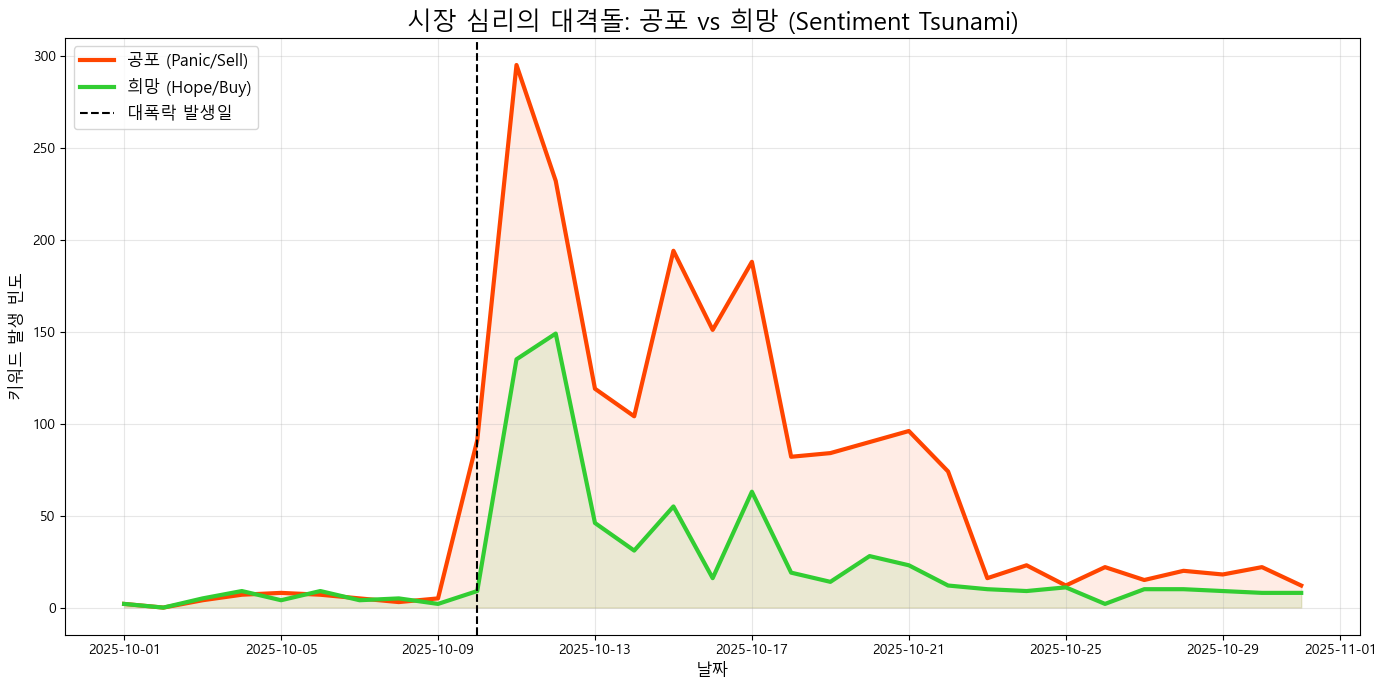

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# ==========================================
# [시각화 1] 감정의 파도 (Panic vs Hope)
# ==========================================

# 1. 감정 키워드 사전 정의 (분석가가 직접 정의하는 핵심 단어)
panic_keywords = ['panic', 'crash', 'sell', 'dump', 'liquidat', 'rekt', 'scam', 'loss', 'lost', 'dead', 'run']
hope_keywords = ['buy', 'dip', 'hold', 'moon', 'rally', 'opportunity', 'support', 'long', 'recovery', 'bounce']

# 2. 점수 계산 함수
def count_keywords(text, keywords):
    count = 0
    for k in keywords:
        if k in str(text).lower():
            count += 1
    return count

# 3. 데이터프레임에 적용 (df_focus는 10월 데이터)
df_focus['panic_score'] = df_focus['clean_content'].apply(lambda x: count_keywords(x, panic_keywords))
df_focus['hope_score'] = df_focus['clean_content'].apply(lambda x: count_keywords(x, hope_keywords))

# 4. 날짜별 합계 집계
daily_sentiment = df_focus.groupby('date_dt')[['panic_score', 'hope_score']].sum()

# 5. 시각화
plt.figure(figsize=(14, 7))

# 부드러운 곡선 연출을 위해 interpolate 사용 가능 (선택사항)
plt.plot(daily_sentiment.index, daily_sentiment['panic_score'], color='#FF4500', linewidth=3, label='공포 (Panic/Sell)')
plt.plot(daily_sentiment.index, daily_sentiment['hope_score'], color='#32CD32', linewidth=3, label='희망 (Hope/Buy)')

# 영역 채우기 (쓰나미 효과)
plt.fill_between(daily_sentiment.index, daily_sentiment['panic_score'], color='#FF4500', alpha=0.1)
plt.fill_between(daily_sentiment.index, daily_sentiment['hope_score'], color='#32CD32', alpha=0.1)

# 강조선 (10월 10일)
plt.axvline(pd.to_datetime('2025-10-10'), color='black', linestyle='--', linewidth=1.5, label='대폭락 발생일')

plt.title('시장 심리의 대격돌: 공포 vs 희망 (Sentiment Tsunami)', fontsize=18)
plt.xlabel('날짜', fontsize=12)
plt.ylabel('키워드 발생 빈도', fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# 저장
plt.savefig(os.path.join(output_dir, 'sentiment_tsunami.png'), dpi=300)
plt.show()

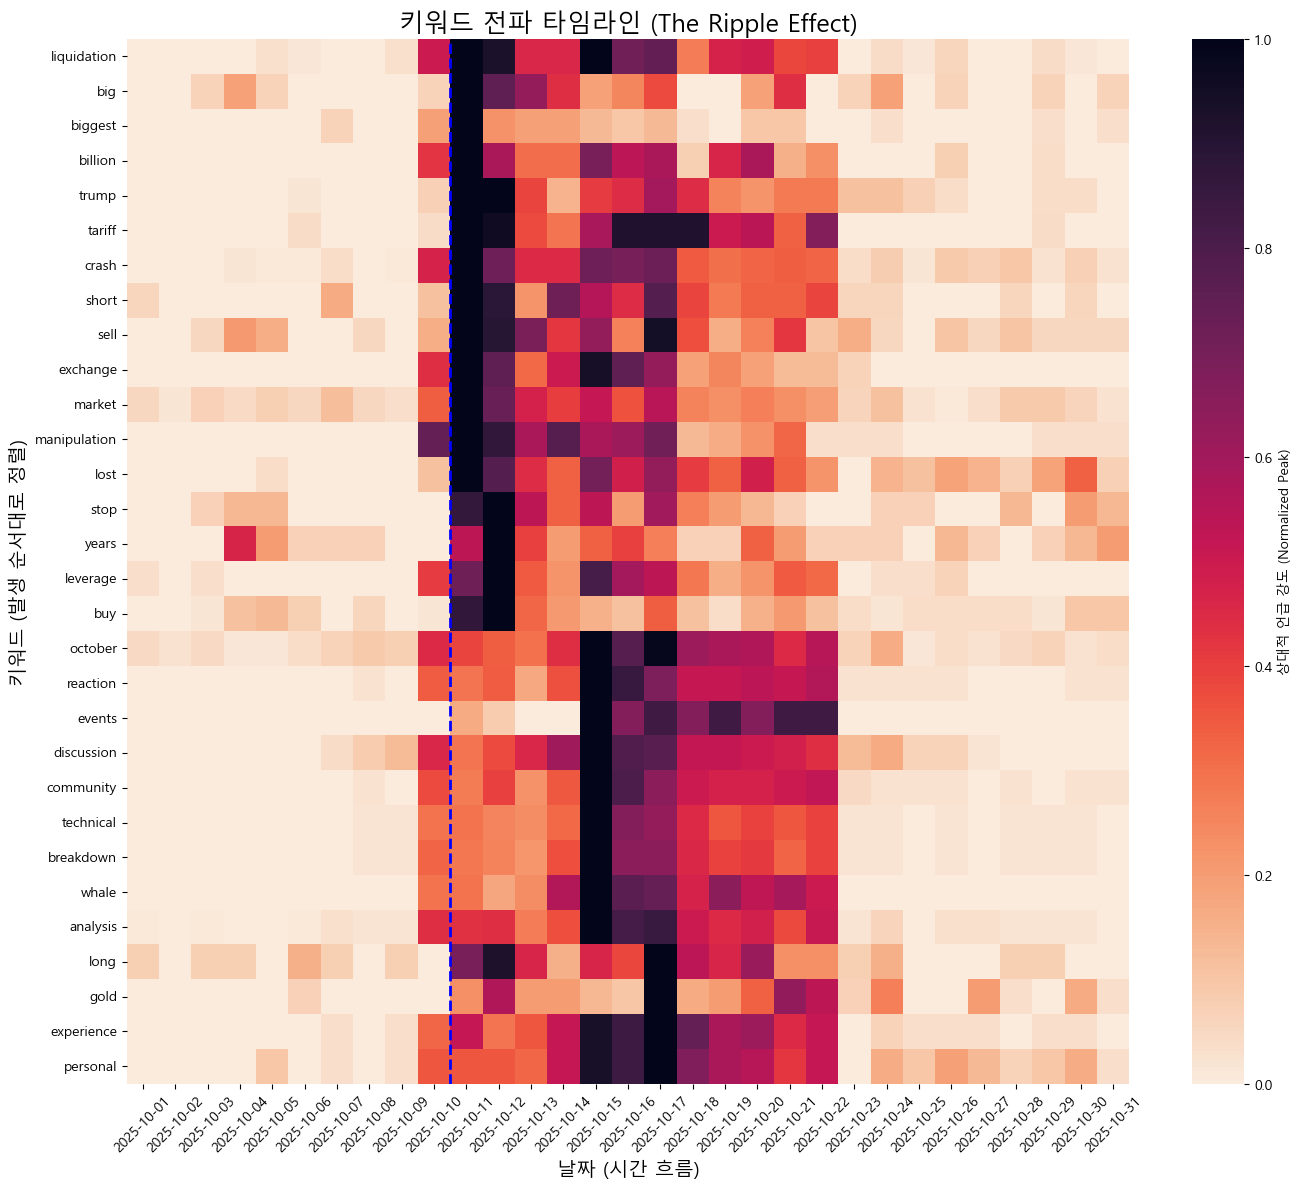

In [17]:
# ==========================================
# [시각화 2] 키워드 전파 타임라인 (Ripple Effect Heatmap)
# ==========================================

# 1. 기존 heatmap_data 활용
# 각 단어(행)별로 '가장 많이 언급된 날짜(Peak Date)'를 찾습니다.
peak_dates = heatmap_data.idxmax(axis=1)

# 2. 피크 날짜 순서대로 단어(행) 정렬
sorted_keywords = peak_dates.sort_values().index
sorted_heatmap_data = heatmap_data.loc[sorted_keywords]

# 3. 정규화 (선택사항: 날짜별 빈도 차이가 너무 크면 0~1로 스케일링하여 패턴 강조)
normalized_heatmap = sorted_heatmap_data.div(sorted_heatmap_data.max(axis=1), axis=0)

# 4. 시각화
plt.figure(figsize=(14, 12))
sns.heatmap(normalized_heatmap, 
            cmap='rocket_r',  # 강렬한 색상 테마
            xticklabels=True, 
            yticklabels=True,
            cbar_kws={'label': '상대적 언급 강도 (Normalized Peak)'})

plt.title('키워드 전파 타임라인 (The Ripple Effect)', fontsize=18)
plt.xlabel('날짜 (시간 흐름)', fontsize=14)
plt.ylabel('키워드 (발생 순서대로 정렬)', fontsize=14)
plt.xticks(rotation=45)

# 10일 경계선
dates_list = list(normalized_heatmap.columns)
try:
    target_idx = [i for i, d in enumerate(dates_list) if '10-10' in d][0]
    plt.axvline(x=target_idx + 1, color='blue', linestyle='--', linewidth=2)
except:
    pass

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'keyword_ripple_effect.png'), dpi=300)
plt.show()

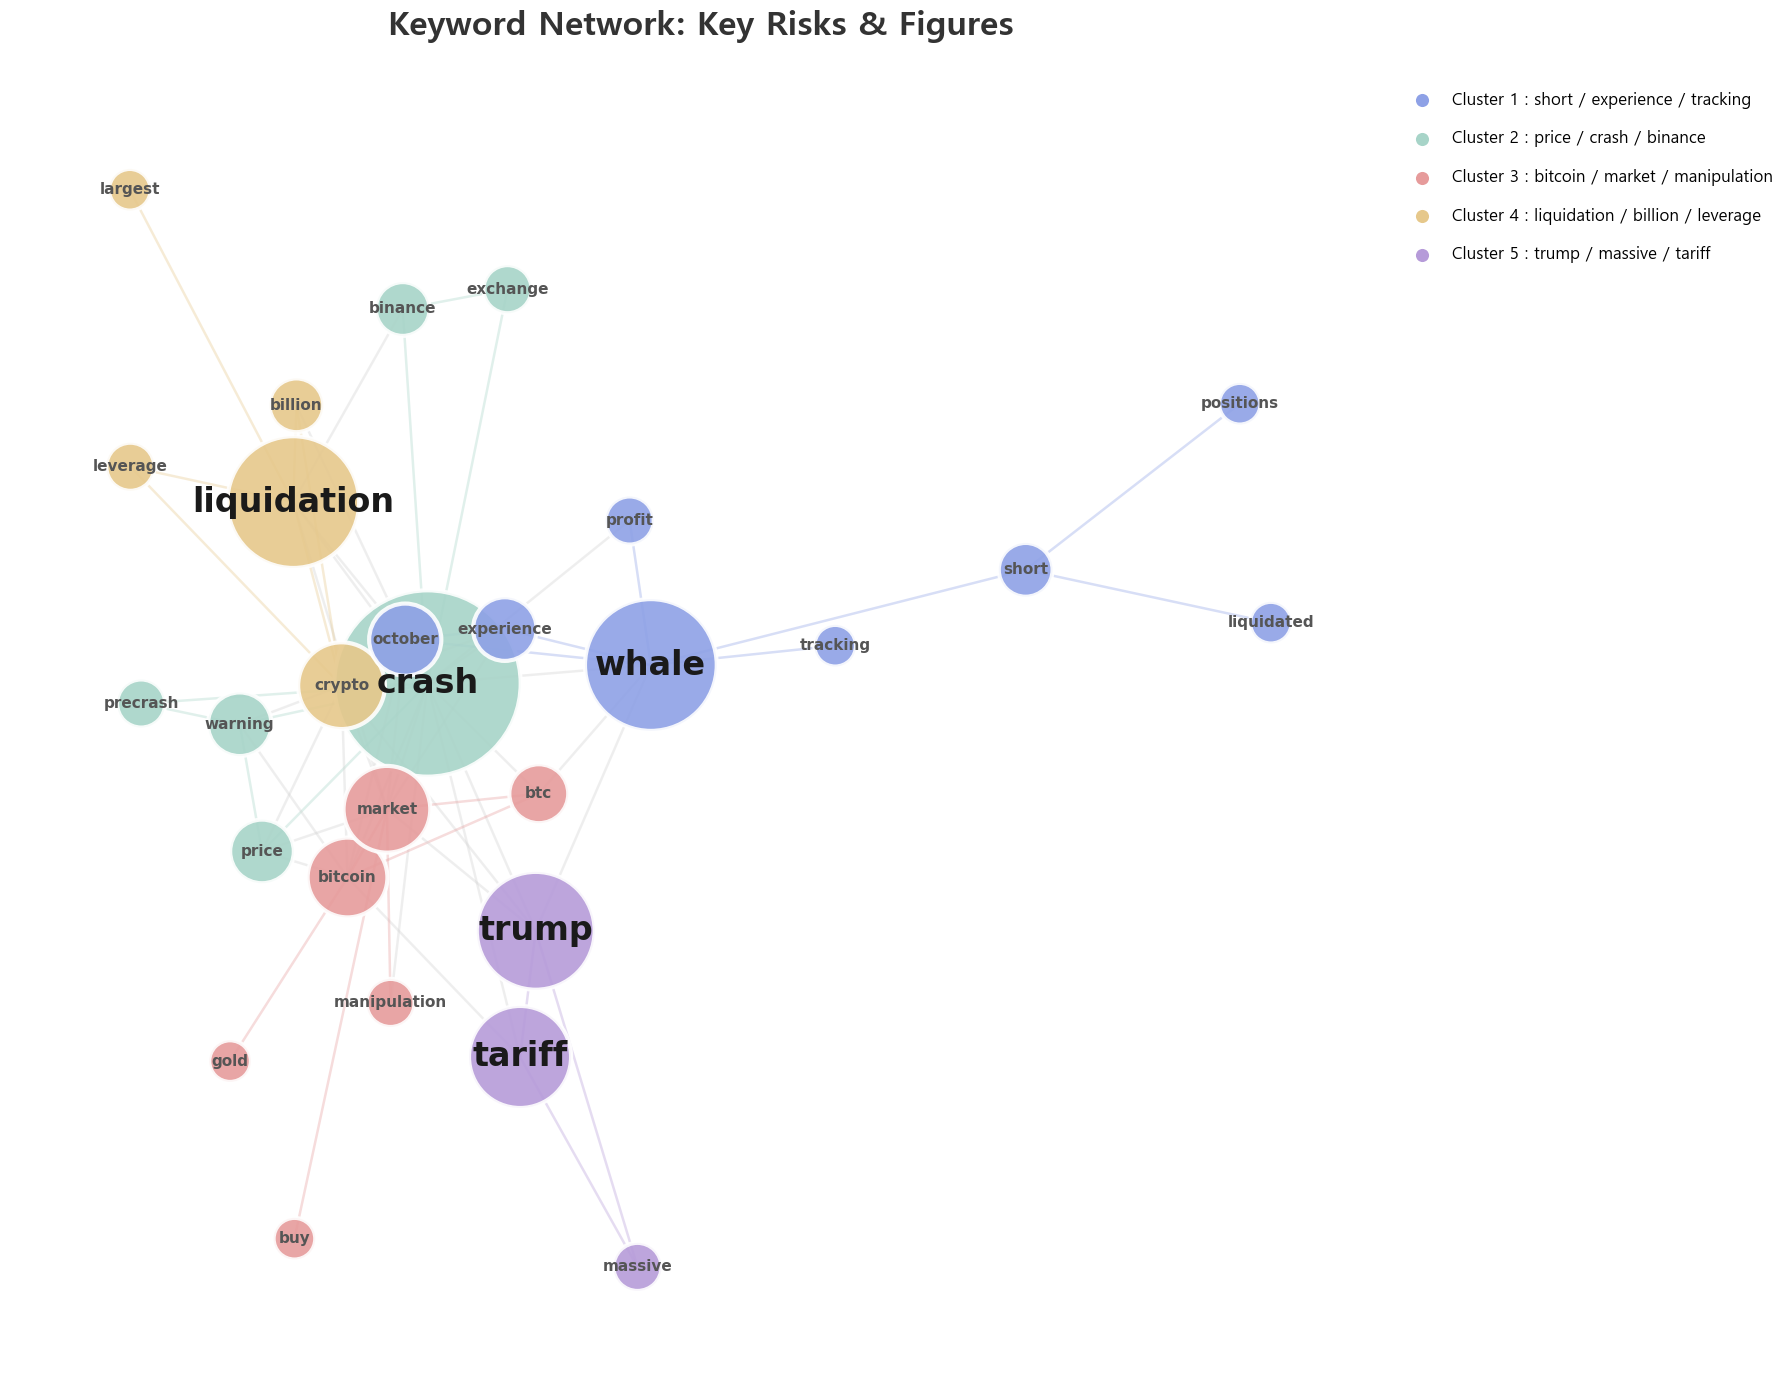

✅ 'new' 제거 완료.
✅ 강조 그룹: TRUMP, TARIFF, WHALE, CRASH, LIQUIDATION (총 5개)


In [32]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from networkx.algorithms.community import greedy_modularity_communities
from itertools import cycle

# ==========================================
# 1. 데이터 로드
# ==========================================
try:
    df = pd.read_csv('Total_Data.csv')
except FileNotFoundError:
    df = pd.DataFrame({'content': []}) 

# ==========================================
# 2. [전처리] 'new' 제거 및 데이터 정제
# ==========================================
stopwords_garbage = [
    # 🚨 [추가 요청 반영]
    'new', 
    'coming', 'news', 'dont', 'did', 'money', 'like', 'eth', 'daily',

    # 기존 불용어
    'analysis', 'event', 'events', 'reaction', 'reactions', 'personal',
    'video', 'youtube', 'channel', 'link', 'subscribe', 'sub', 
    'watch', 'live', 'stream', 'episode', 'clip', 'review',
    'update', 'discussion', 'community', 'breakdown', 'technical',
    'thing', 'things', 'people', 'guy', 'guys', 'lot', 'way', 'part',
    'time', 'year', 'years', 'day', 'days', 'week', 'weeks', 'today',
    'look', 'see', 'know', 'think', 'make', 'use', 'get', 'go', 'come',
    'good', 'bad', 'great', 'big', 'small', 'high', 'low', 'real', 'long',
    'actually', 'really', 'just', 'maybe', 'probably', 'sure', 'now', 'still',
    'im', 'und', 'ist', 'das', 'der', 'die', 'auf', 'fuer', 'mit', 'den', 
    'von', 'nicht', 'ein', 'eine', 'dem', 'sind', 'man', 'aus', 'wie', 'bei'
]

# 유의어 통합
synonym_map = {
    'crashes': 'crash', 'tariffs': 'tariff', 'prices': 'price', 'markets': 'market',
    'coins': 'coin', 'banks': 'bank', 'governments': 'govt', 'government': 'govt',
    'investors': 'investor', 'rates': 'rate', 'losses': 'loss', 'funds': 'fund',
    'liquidations': 'liquidation' # 복수형 처리 추가
}

def smart_clean(text):
    if not isinstance(text, str): return ""
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = text.split()
    refined_words = []
    for w in words:
        if len(w) < 3: continue
        if w in stopwords_garbage: continue 
        w = synonym_map.get(w, w)
        refined_words.append(w)
    return ' '.join(refined_words)

if 'content' in df.columns:
    df['clean_content'] = df['content'].apply(smart_clean)

# ==========================================
# 3. 네트워크 생성
# ==========================================
vectorizer = CountVectorizer(stop_words='english', max_features=50, min_df=3)
X = vectorizer.fit_transform(df['clean_content'])
words = vectorizer.get_feature_names_out()

Xc = (X.T * X)
Xc.setdiag(0)
G = nx.Graph()
cx = Xc.tocoo()

# Threshold 92% 유지 (깔끔한 분리)
threshold = np.percentile(cx.data, 92) 

for i, j, v in zip(cx.row, cx.col, cx.data):
    if v > threshold:
        G.add_edge(words[i], words[j], weight=v)

G.remove_nodes_from(list(nx.isolates(G)))

# 커뮤니티 감지
communities = list(greedy_modularity_communities(G))
valid_communities = [c for c in communities if len(c) >= 3]

node_groups = {}
nodes_to_keep = set()
for i, comm in enumerate(valid_communities):
    for node in comm:
        node_groups[node] = i
        nodes_to_keep.add(node)

G.remove_nodes_from([n for n in G.nodes() if n not in nodes_to_keep])

# ==========================================
# 4. [시각화] 5대장 강조 (Highlights)
# ==========================================

# 색상
pastel_colors = [
    "#8EA1E6", "#A7D4C8", "#E69B9B", "#E6C88B", "#B69BD9", "#F2C5A2", 
    "#96C0CE", "#D9A6A6", "#C4D9A6", "#D9C4A6"
]
color_cycle = cycle(pastel_colors)
group_colors = [next(color_cycle) for _ in range(len(valid_communities))]
node_color_map = [group_colors[node_groups[n]] for n in G.nodes()]

# [핵심 수정] 강조 단어 리스트 업데이트
highlight_words = ['trump', 'tariff', 'whale', 'crash', 'liquidation']

plt.figure(figsize=(18, 14), facecolor='white')

# 레이아웃 (넓게)
pos = nx.spring_layout(G, k=3.0, iterations=200, seed=42) 

# 노드 크기
d = dict(G.degree)
node_sizes = []
for n in G.nodes():
    base_size = d[n] * 300 + 600
    if n in highlight_words:
        node_sizes.append(base_size * 3.0) # 강조 단어는 3배 확대
    else:
        node_sizes.append(base_size)

# 엣지 그리기
edge_colors = []
for u, v in G.edges():
    if node_groups[u] == node_groups[v]:
        edge_colors.append(group_colors[node_groups[u]])
    else:
        edge_colors.append('#d1d1d1')

nx.draw_networkx_edges(G, pos, edge_color=edge_colors, alpha=0.35, width=1.8)

# 노드 그리기
nx.draw_networkx_nodes(G, pos, 
                       node_color=node_color_map, 
                       node_size=node_sizes, 
                       alpha=0.9, 
                       edgecolors='white', 
                       linewidths=3)

# 일반 라벨
normal_nodes = [n for n in G.nodes() if n not in highlight_words]
nx.draw_networkx_labels(G, pos, 
                        labels={n: n for n in normal_nodes},
                        font_family='sans-serif', font_size=11, 
                        font_color='#555555', font_weight='bold')

# [강조 라벨] 폰트 사이즈 키우고 색상 진하게
nx.draw_networkx_labels(G, pos, 
                        labels={n: n for n in highlight_words},
                        font_family='sans-serif', font_size=24, # 폰트 24pt
                        font_color='#1a1a1a',  # 거의 검정
                        font_weight='heavy')

plt.title("Keyword Network: Key Risks & Figures", fontsize=24, color='#333333', pad=30, weight='bold')
plt.axis('off')

# 범례
for i in range(len(valid_communities)):
    top_words = list(valid_communities[i])[:3]
    plt.scatter([], [], c=group_colors[i], s=120, edgecolors='white', linewidth=1.5,
                label=f"Cluster {i+1} : {' / '.join(top_words)}")

plt.legend(scatterpoints=1, frameon=False, fontsize=12, loc='upper left', 
           bbox_to_anchor=(1, 1), labelspacing=1.3)

plt.tight_layout()
plt.savefig('network_analysis_final_highlight.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 'new' 제거 완료.")
print("✅ 강조 그룹: TRUMP, TARIFF, WHALE, CRASH, LIQUIDATION (총 5개)")

--- [1단계] 파일 읽기 ---

--- [2단계] 날짜 변환 (수정됨) ---
📅 타겟 날짜 컬럼: 'date'
✅ 날짜 변환 성공! 기간: 2025-09-01 ~ 2025-10-31

--- [3단계] 키워드 분석 ---

--- [4단계] 그래프 그리기 ---


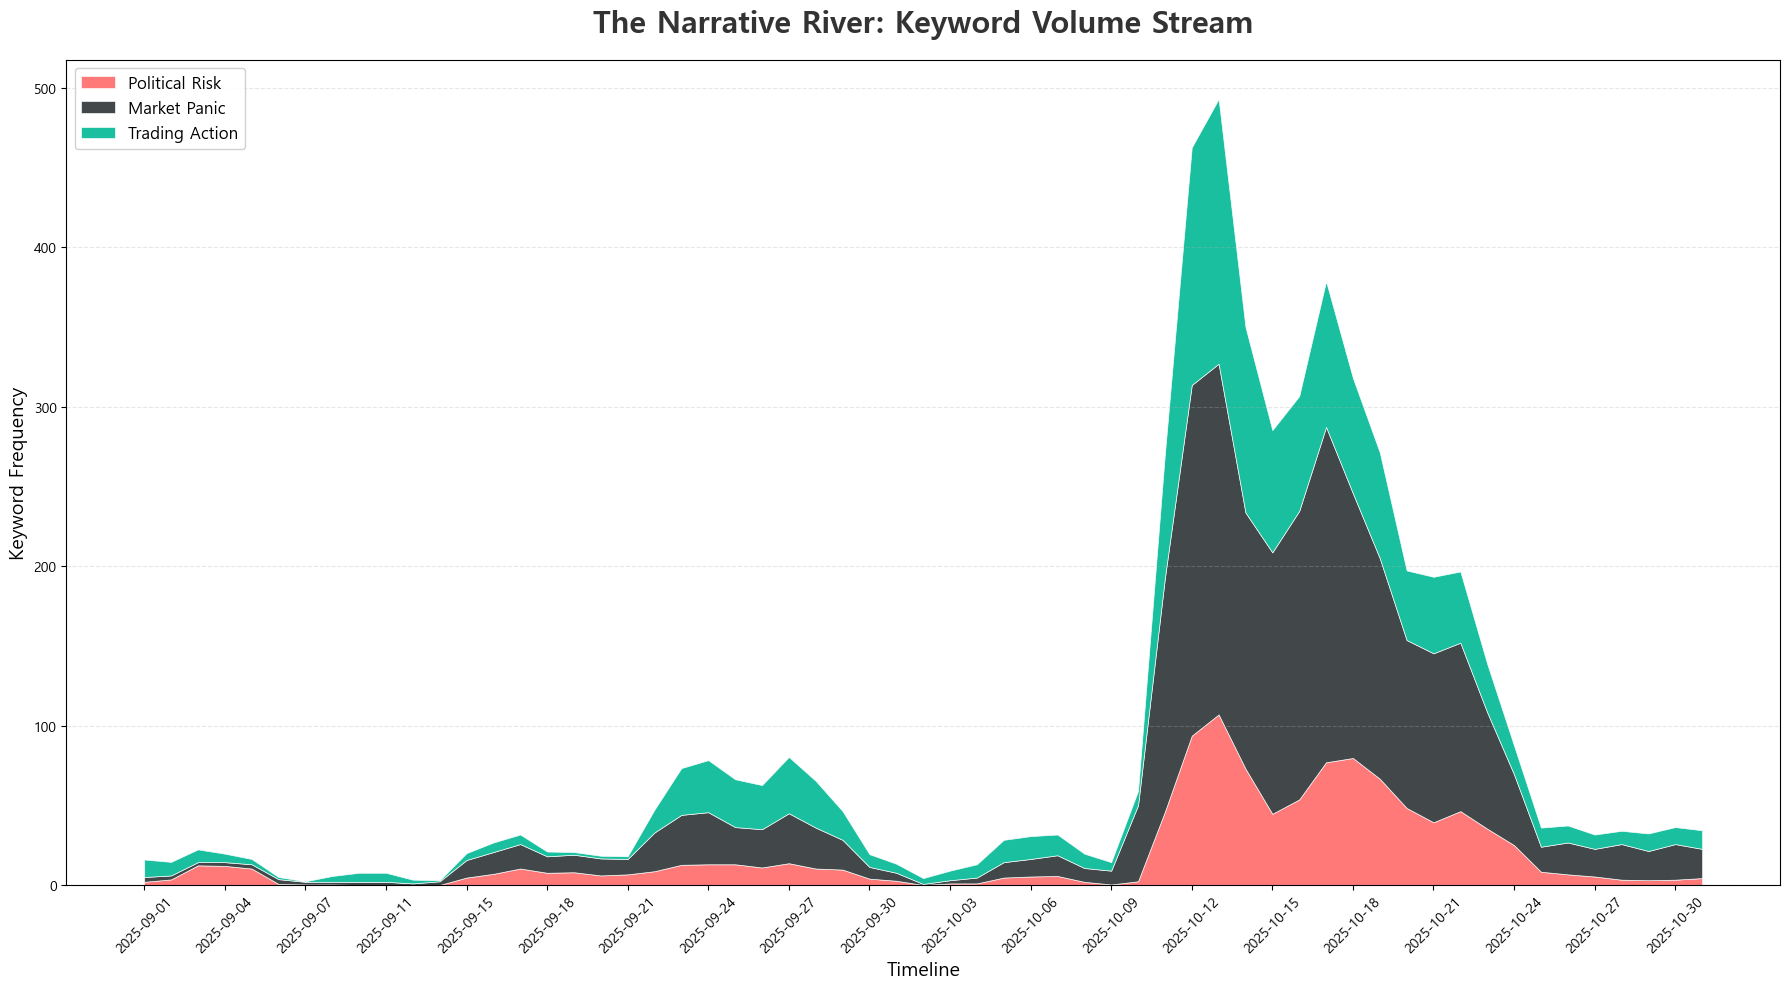

✅ 완료! 정상적으로 저장되었습니다: narrative_streamgraph_final.png


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import sys

# ==========================================
# 1. 파일 로드
# ==========================================
file_path = r'C:\junwoo\AI_Project_01_Team6\data\Community_data\FINAL_SNS_YOUTUBE.csv'

print("--- [1단계] 파일 읽기 ---")
try:
    df = pd.read_csv(file_path, encoding='utf-8-sig')
except UnicodeDecodeError:
    try:
        df = pd.read_csv(file_path, encoding='cp949')
    except Exception as e:
        print(f"❌ 파일 읽기 실패: {e}")
        sys.exit()

# ==========================================
# 2. [핵심 수정] 날짜 포맷 강제 지정
# ==========================================
print("\n--- [2단계] 날짜 변환 (수정됨) ---")
# 자동으로 'date' 컬럼 찾기
date_col = [c for c in df.columns if 'date' in c.lower()][0]
print(f"📅 타겟 날짜 컬럼: '{date_col}'")

# [중요] 숫자로 된 날짜(20250901)를 문자로 바꾸고 -> 날짜로 변환
# errors='coerce'는 변환 안 되는 이상한 값은 지워버리라는 뜻
df[date_col] = df[date_col].astype(str).str.strip()
df['dt_parsed'] = pd.to_datetime(df[date_col], format='%Y%m%d', errors='coerce')

# 만약 위 방식으로 안 되면(형식이 섞여있으면) 일반 방식으로 재시도
if df['dt_parsed'].isnull().sum() > len(df) * 0.5:
    print("⚠️ YYYYMMDD 형식이 아닌 것 같아 자동 파싱을 시도합니다.")
    df['dt_parsed'] = pd.to_datetime(df[date_col], errors='coerce')

# 유효한 날짜만 남기기
df = df.dropna(subset=['dt_parsed'])
df['date_str'] = df['dt_parsed'].dt.strftime('%Y-%m-%d')
dates = sorted(df['date_str'].unique())

print(f"✅ 날짜 변환 성공! 기간: {dates[0]} ~ {dates[-1]}")
if dates[0] == '1970-01-01':
    print("❌ 여전히 1970년으로 나옵니다. 데이터의 날짜 값을 확인해주세요.")
    sys.exit()

# ==========================================
# 3. 키워드 카운팅
# ==========================================
print("\n--- [3단계] 키워드 분석 ---")
# 본문 컬럼 찾기
text_col = [c for c in df.columns if any(x in c.lower() for x in ['content', 'text', 'body'])][0]

# 텍스트 전처리 (소문자 변환)
df['clean_text'] = df[text_col].astype(str).str.lower()

# 내러티브 키워드 정의
topic_keywords = {
    'Political Risk': ['trump', 'tariff', 'govt', 'biden', 'policy', 'china', 'tax', 'war'],
    'Market Panic': ['crash', 'liquidation', 'panic', 'dump', 'loss', 'fear', 'collapse', 'risk', 'crisis', 'down'],
    'Trading Action': ['buy', 'long', 'short', 'pump', 'moon', 'profit', 'bull', 'rally', 'opportunity', 'gain']
}

# 날짜별 집계
topic_data = {topic: [] for topic in topic_keywords}

for d in dates:
    # 하루치 텍스트 몽땅 합치기
    daily_text = " ".join(df[df['date_str'] == d]['clean_text'].tolist())
    
    for topic, keywords in topic_keywords.items():
        count = 0
        for k in keywords:
            count += daily_text.count(k)
        topic_data[topic].append(count)

# ==========================================
# 4. 시각화 (Streamgraph)
# ==========================================
print("\n--- [4단계] 그래프 그리기 ---")
stream_df = pd.DataFrame(topic_data, index=dates).astype(float)

# 이동평균으로 곡선 부드럽게 (데이터가 적으면 window=1)
window = 3 if len(dates) > 10 else 1
stream_df_smooth = stream_df.rolling(window=window, min_periods=1).mean().fillna(0)

plt.figure(figsize=(18, 10), facecolor='white')

# 색상: 정치(Red), 공포(Dark), 희망(Green)
colors = ['#FF6B6B', '#2D3436', '#00B894'] 
x_idx = np.arange(len(dates))

# 스택플롯 그리기
plt.stackplot(x_idx, stream_df_smooth.T, labels=stream_df_smooth.columns, colors=colors, alpha=0.9, edgecolor='white', linewidth=0.5)

plt.title("The Narrative River: Keyword Volume Stream", fontsize=22, fontweight='bold', pad=20, color='#333333')
plt.xlabel("Timeline", fontsize=14)
plt.ylabel("Keyword Frequency", fontsize=14)

# X축 라벨 (날짜 표시)
step = max(1, len(dates) // 15)
plt.xticks(ticks=x_idx[::step], labels=dates[::step], rotation=45, fontsize=10)

plt.legend(loc='upper left', fontsize=12, frameon=True, framealpha=0.9)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()

# 저장 및 출력
output_path = 'narrative_streamgraph_final.png'
plt.savefig(output_path, dpi=300)
plt.show()

print(f"✅ 완료! 정상적으로 저장되었습니다: {output_path}")

[*********************100%***********************]  1 of 1 completed

📅 분석 기간: 2025-09-01 ~ 2025-10-31

--- [2단계] 비트코인 가격 데이터 로드 ---
✅ 가격 데이터 연동 성공! (58일 매칭됨)


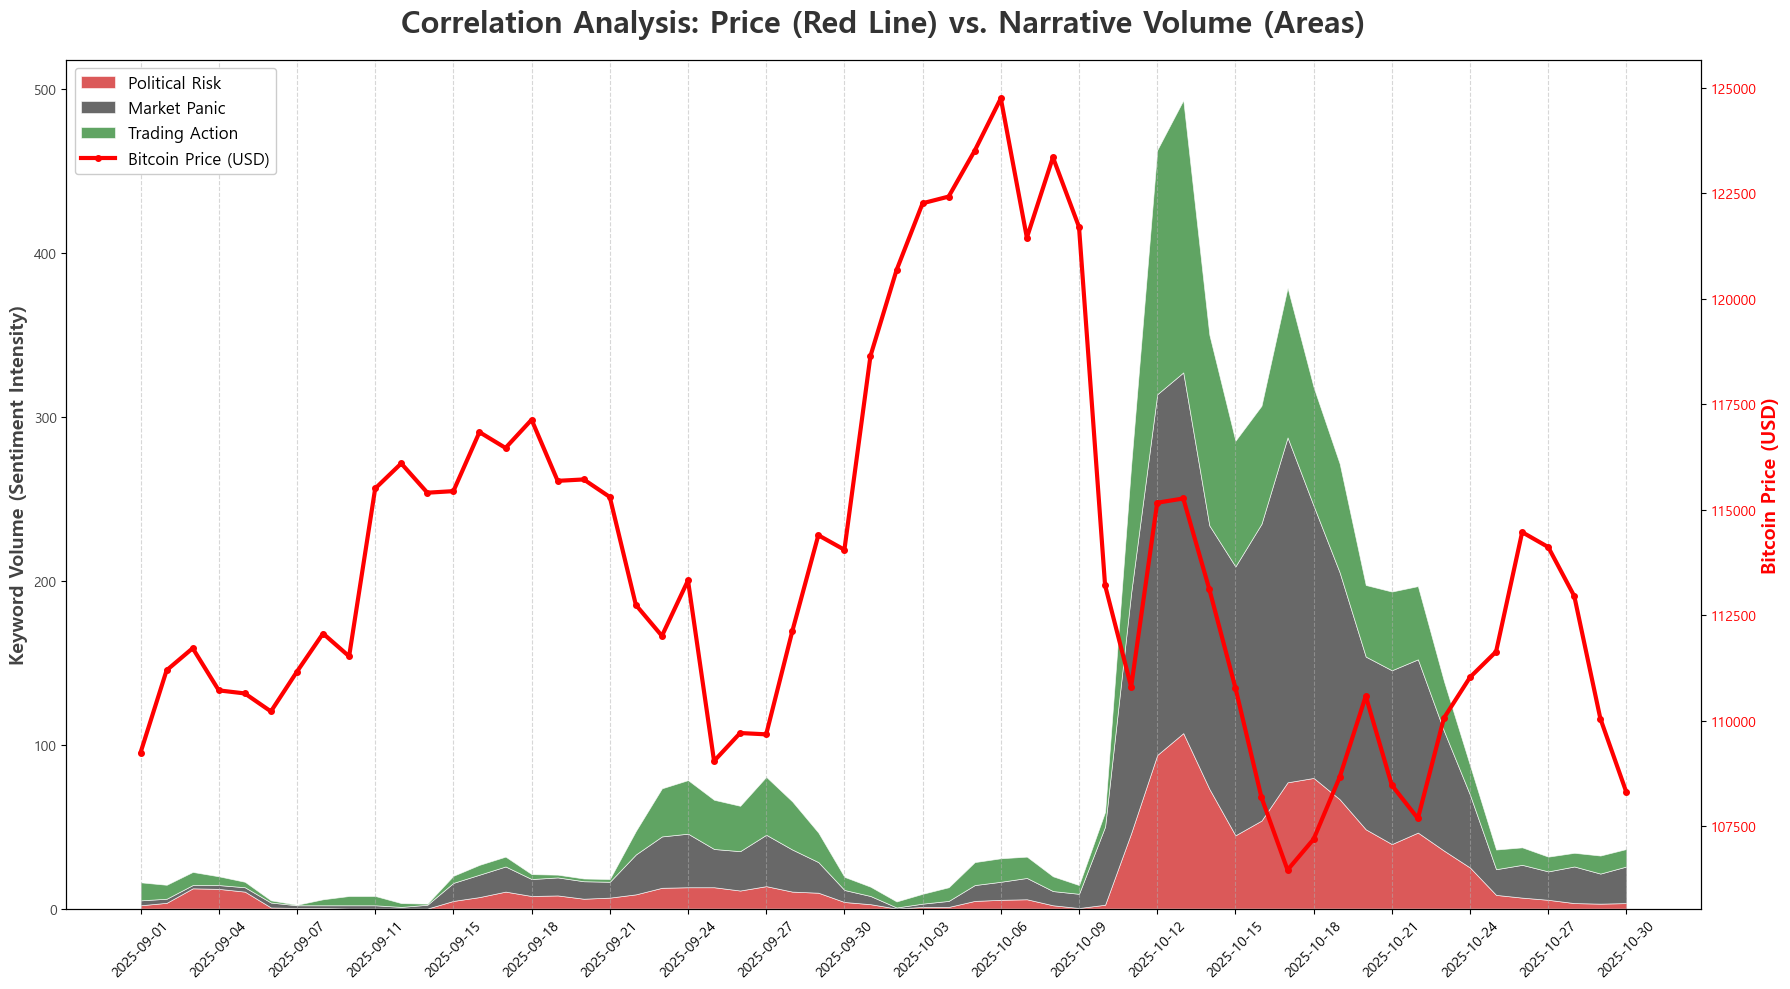

✅ 시각화 완료! 파일 저장됨: narrative_price_correlation_vivid.png


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import re
import sys

# ==========================================
# 1. 커뮤니티 데이터 로드 및 전처리 (기존 유지)
# ==========================================
file_path = r'C:\junwoo\AI_Project_01_Team6\data\Community_data\FINAL_SNS_YOUTUBE.csv'

try:
    df = pd.read_csv(file_path, encoding='utf-8-sig')
except:
    try:
        df = pd.read_csv(file_path, encoding='cp949')
    except:
        print("❌ 파일 로드 실패")
        sys.exit()

# 날짜 변환
date_col = [c for c in df.columns if 'date' in c.lower()][0]
df[date_col] = df[date_col].astype(str).str.strip()
df['dt_parsed'] = pd.to_datetime(df[date_col], format='%Y%m%d', errors='coerce')

if df['dt_parsed'].isnull().sum() > len(df) * 0.5:
    df['dt_parsed'] = pd.to_datetime(df[date_col], errors='coerce')

df = df.dropna(subset=['dt_parsed'])
df['date_str'] = df['dt_parsed'].dt.strftime('%Y-%m-%d')
dates = sorted(df['date_str'].unique())

start_date = dates[0]
end_date = dates[-1]
print(f"📅 분석 기간: {start_date} ~ {end_date}")

# 텍스트 전처리 및 키워드 집계
text_col = [c for c in df.columns if any(x in c.lower() for x in ['content', 'text', 'body'])][0]
df['clean_text'] = df[text_col].astype(str).str.lower()

topic_keywords = {
    'Political Risk': ['trump', 'tariff', 'govt', 'biden', 'policy', 'china', 'tax', 'war'],
    'Market Panic': ['crash', 'liquidation', 'panic', 'dump', 'loss', 'fear', 'collapse', 'risk', 'crisis', 'down'],
    'Trading Action': ['buy', 'long', 'short', 'pump', 'moon', 'profit', 'bull', 'rally', 'opportunity', 'gain']
}

topic_data = {topic: [] for topic in topic_keywords}
for d in dates:
    daily_text = " ".join(df[df['date_str'] == d]['clean_text'].tolist())
    for topic, keywords in topic_keywords.items():
        count = 0
        for k in keywords:
            count += daily_text.count(k)
        topic_data[topic].append(count)

narrative_df = pd.DataFrame(topic_data, index=dates)

# ==========================================
# 2. 비트코인 가격 데이터 로드 (기존 유지)
# ==========================================
print("\n--- [2단계] 비트코인 가격 데이터 로드 ---")
try:
    btc_df = yf.download("BTC-USD", start=start_date, end=end_date)
    if btc_df.empty:
        end_dt = pd.to_datetime(end_date) + pd.Timedelta(days=1)
        btc_df = yf.download("BTC-USD", start=start_date, end=end_dt)

    btc_df.index = btc_df.index.strftime('%Y-%m-%d')
    common_dates = sorted(list(set(dates) & set(btc_df.index)))
    
    narrative_df = narrative_df.loc[common_dates]
    price_series = btc_df.loc[common_dates]['Close']
    print(f"✅ 가격 데이터 연동 성공! ({len(common_dates)}일 매칭됨)")

except Exception as e:
    print(f"❌ 비트코인 데이터 로드 실패: {e}")
    price_series = pd.Series(np.random.randint(50000, 60000, len(dates)), index=dates)

# ==========================================
# 3. [시각화 수정] 가격(빨강) + 볼륨(선명하게)
# ==========================================
fig, ax1 = plt.subplots(figsize=(18, 10), facecolor='white')

# (1) 배경: 내러티브 영역 차트 (왼쪽 축)
# 색상 팔레트 (정치: 진한 빨강, 공포: 진한 회색, 매매: 진한 초록)
colors = ['#D32F2F', '#424242', '#388E3C'] 
x_idx = np.arange(len(narrative_df))

# 부드러운 곡선
window = 3 if len(narrative_df) > 5 else 1
narrative_smooth = narrative_df.rolling(window=window, min_periods=1).mean().fillna(0)

# [핵심 수정 1] alpha 값을 높여서(0.4 -> 0.8) 색상을 선명하게 만듦
ax1.stackplot(x_idx, narrative_smooth.T, labels=narrative_smooth.columns, 
              colors=colors, alpha=0.8, edgecolor='white', linewidth=0.5)

ax1.set_ylabel("Keyword Volume (Sentiment Intensity)", fontsize=14, color='#424242', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='#424242')

# (2) 전경: 비트코인 가격 선 차트 (오른쪽 축)
ax2 = ax1.twinx()

# [핵심 수정 2] 가격 선 색상을 빨간색(#FF0000)으로 변경
ax2.plot(x_idx, price_series.values, color='#FF0000', linewidth=3, linestyle='-', marker='o', markersize=4, label='Bitcoin Price (USD)')
ax2.set_ylabel("Bitcoin Price (USD)", fontsize=14, color='#FF0000', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='#FF0000')

# 타이틀 및 스타일
plt.title("Correlation Analysis: Price (Red Line) vs. Narrative Volume (Areas)", fontsize=22, fontweight='bold', pad=20, color='#333333')

# X축 라벨
step = max(1, len(narrative_df) // 15)
ax1.set_xticks(x_idx[::step])
ax1.set_xticklabels(narrative_df.index[::step], rotation=45, fontsize=10)

# 범례 합치기
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# 범례 배경도 불투명하게 해서 잘 보이게 함
ax2.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=12, frameon=True, framealpha=1.0, facecolor='white', edgecolor='#cccccc')

# 그리드
ax1.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
output_path = 'narrative_price_correlation_vivid.png'
plt.savefig(output_path, dpi=300)
plt.show()

print(f"✅ 시각화 완료! 파일 저장됨: {output_path}")

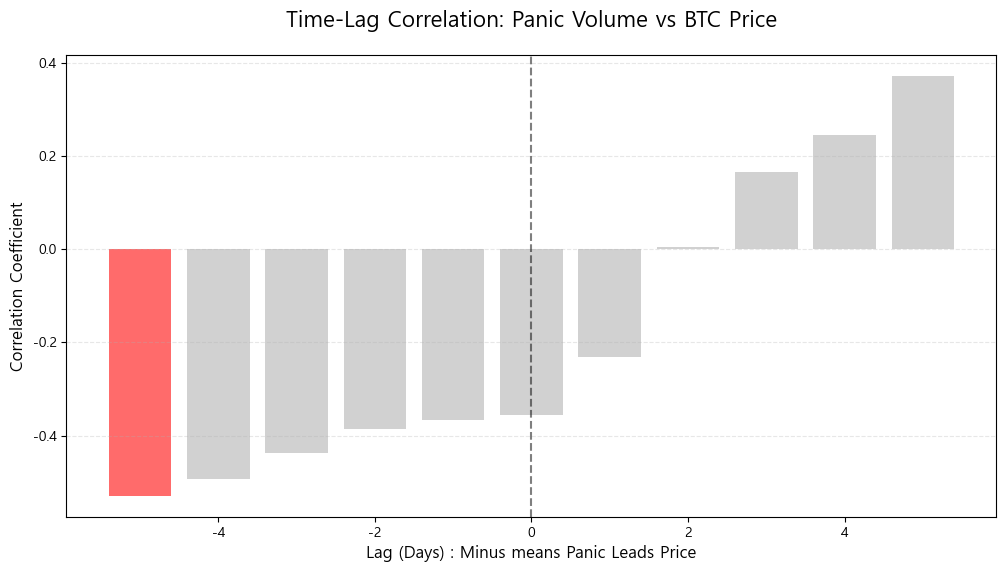

💡 분석 결과: Panic 키워드는 가격 변동보다 약 5일 정도 선행하여 움직이는 경향이 있습니다.


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. 데이터 병합 (이전 코드에서 생성한 narrative_df와 price_series 활용)
analysis_df = pd.concat([narrative_df['Market Panic'], price_series], axis=1)
analysis_df.columns = ['Panic_Volume', 'BTC_Price']

# 2. 시차(Lag) 분석: Panic 키워드가 가격에 몇 일 선행하는가?
lags = range(-5, 6) # -5일부터 +5일까지 조사
correlations = []

for lag in lags:
    # 가격 데이터를 lag만큼 밀어서 상관관계 계산
    corr = analysis_df['Panic_Volume'].corr(analysis_df['BTC_Price'].shift(lag))
    correlations.append(corr)

# 3. 시각화 (어느 지점에서 상관관계가 가장 큰지 확인)
plt.figure(figsize=(12, 6), facecolor='white')
plt.bar(lags, correlations, color=['#FF6B6B' if c == min(correlations) else '#D1D1D1' for c in correlations])

plt.title("Time-Lag Correlation: Panic Volume vs BTC Price", fontsize=16, pad=20)
plt.xlabel("Lag (Days) : Minus means Panic Leads Price", fontsize=12)
plt.ylabel("Correlation Coefficient", fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.show()

# 인사이트 출력
best_lag = lags[np.argmin(correlations)] # 가격과 음의 상관관계(폭락)가 가장 강한 시점
print(f"💡 분석 결과: Panic 키워드는 가격 변동보다 약 {abs(best_lag)}일 정도 선행하여 움직이는 경향이 있습니다.")

In [48]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
비정형 데이터 선행성 입증 - 데이터 수집기 (수정완료 버전)
작성자: Ha Jun-woo (Refined by Gemini)
목표: 2025년 10월 검은화요일 vs 2026년 1-2월 폭락 데이터 수집 및 CSV 저장
"""

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import yfinance as yf
import requests
import json
import time
import os

# ============================================================================
# 설정 (Configuration)
# ============================================================================

PERIOD_1 = {
    'name': '2025_Oct_BlackTuesday',
    'start': '2025-10-07',
    'end': '2025-10-13',
    'description': '검은 10월 (October 10 crash)'
}

PERIOD_2 = {
    'name': '2026_Jan_Feb_Crash',
    'start': '2026-01-28',
    'end': '2026-02-05',
    'description': '2026년 1월말-2월초 폭락'
}

OUTPUT_DIR = './crash_analysis_data'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("=" * 100)
print("비정형 데이터 선행성 분석 - 데이터 수집기 (Fixed Version)")
print("=" * 100)
print(f"기간 1: {PERIOD_1['start']} ~ {PERIOD_1['end']}")
print(f"기간 2: {PERIOD_2['start']} ~ {PERIOD_2['end']}")
print()

# ============================================================================
# 데이터 수집 함수 정의
# ============================================================================

def collect_price_data(start_date, end_date):
    """
    [1/6] 가격 데이터 수집 (Yahoo Finance)
    """
    print("  [1/6] 가격 데이터 수집 중...")
    
    # 등락률 계산을 위해 시작일 하루 전부터 가져옴
    start = pd.to_datetime(start_date) - timedelta(days=2)
    end = pd.to_datetime(end_date) + timedelta(days=1)
    
    try:
        # yfinance 최신 버전 대응 (auto_adjust=True 추천)
        btc = yf.download('BTC-USD', start=start, end=end, progress=False, auto_adjust=True)
        eth = yf.download('ETH-USD', start=start, end=end, progress=False, auto_adjust=True)
        
        # 멀티인덱스 컬럼 평탄화 (yfinance 버전에 따라 컬럼이 튜플일 수 있음)
        if isinstance(btc.columns, pd.MultiIndex):
            btc.columns = btc.columns.get_level_values(0)
        if isinstance(eth.columns, pd.MultiIndex):
            eth.columns = eth.columns.get_level_values(0)

        # 필요한 컬럼만 선택 및 이름 변경
        btc = btc[['Close', 'Volume']].rename(columns={'Close': 'BTC_Close', 'Volume': 'BTC_Volume'})
        eth = eth[['Close', 'Volume']].rename(columns={'Close': 'ETH_Close', 'Volume': 'ETH_Volume'})
        
        # 날짜 인덱스 통일 (YYYYMMDD)
        price_data = pd.concat([btc, eth], axis=1)
        price_data.index = price_data.index.strftime('%Y%m%d')
        price_data.index.name = 'Date'
        
        # [핵심 수정] 등락률 계산 후 NaN을 0으로 채움 (여기서 에러 발생 방지)
        price_data['BTC_Change_Pct'] = (price_data['BTC_Close'].pct_change() * 100).fillna(0)
        price_data['ETH_Change_Pct'] = (price_data['ETH_Close'].pct_change() * 100).fillna(0)
        
        # 요청한 기간만 자르기
        target_start = pd.to_datetime(start_date).strftime('%Y%m%d')
        target_end = pd.to_datetime(end_date).strftime('%Y%m%d')
        price_data = price_data.loc[target_start:target_end]
        
        print(f"    ✓ BTC, ETH 데이터 확보: {len(price_data)}일")
        return price_data

    except Exception as e:
        print(f"    ✗ 가격 데이터 수집 실패: {e}")
        return pd.DataFrame()

def collect_fear_greed_index(start_date, end_date):
    """
    [2/6] 공포 탐욕 지수 수집
    """
    print("  [2/6] 공포 탐욕 지수 수집 중...")
    try:
        url = "https://api.alternative.me/fng/?limit=365"
        response = requests.get(url, timeout=10)
        data = response.json()
        
        fg_data = []
        for item in data['data']:
            date = datetime.fromtimestamp(int(item['timestamp'])).strftime('%Y%m%d')
            fg_data.append({
                'Date': date,
                'Fear_Greed_Index': int(item['value']),
                'Fear_Greed_Class': item['value_classification']
            })
        
        df_fg = pd.DataFrame(fg_data).set_index('Date')
        
        # 날짜 필터링
        s_date = pd.to_datetime(start_date).strftime('%Y%m%d')
        e_date = pd.to_datetime(end_date).strftime('%Y%m%d')
        df_fg = df_fg.loc[(df_fg.index >= s_date) & (df_fg.index <= e_date)]
        
        print(f"    ✓ 공포 탐욕 지수: {len(df_fg)}일")
        return df_fg
        
    except Exception as e:
        print(f"    ✗ 공포 탐욕 지수 API 에러 (더미 데이터 사용): {e}")
        # 에러 시 빈 DF 반환 (나중에 통합 시 처리됨)
        return pd.DataFrame()

def estimate_social_metrics(start_date, end_date, period_name):
    """
    [3/6] 소셜 미디어 메트릭 추정 (시뮬레이션 데이터)
    """
    print("  [3/6] 소셜 미디어 메트릭 추정 중...")
    
    dates = pd.date_range(start_date, end_date, freq='D')
    date_strs = [d.strftime('%Y%m%d') for d in dates]
    
    # 크래시 날짜 설정
    crash_date = '20251010' if '2025' in period_name else '20260202'
    
    # 베이스 라인 설정
    if '2025' in period_name:
        base = {'reddit': 150, 'twitter': 5000, 'youtube': 20, 'trends': 40}
    else:
        base = {'reddit': 180, 'twitter': 6000, 'youtube': 25, 'trends': 45}
    
    social_data = []
    
    for date_str in date_strs:
        days_diff = (pd.to_datetime(date_str) - pd.to_datetime(crash_date)).days
        
        # 급증 패턴 로직 (-2일 ~ +1일 급증)
        if days_diff == -2:   mult = 1.3
        elif days_diff == -1: mult = 1.8
        elif days_diff == 0:  mult = 3.5 # 당일 폭발
        elif days_diff == 1:  mult = 2.2
        elif days_diff == 2:  mult = 1.5
        else:                 mult = 1.0 + np.random.uniform(-0.1, 0.1)
        
        # 감정 점수 (폭락 전후로 낮아짐)
        if -2 <= days_diff <= 2:
            sentiment = max(10, 50 - (mult * 20) + np.random.randint(-5, 5))
        else:
            sentiment = 50 + np.random.randint(-10, 10)
            
        social_data.append({
            'Date': date_str,
            'Reddit_Posts': int(base['reddit'] * mult),
            'Twitter_Mentions': int(base['twitter'] * mult),
            'YouTube_Videos': int(base['youtube'] * mult),
            'Google_Trends': int(base['trends'] * mult),
            'Sentiment_Score': max(0, min(100, sentiment))
        })
    
    df_social = pd.DataFrame(social_data).set_index('Date')
    print(f"    ✓ 소셜 데이터 생성 완료: {len(df_social)}일")
    return df_social

def estimate_liquidation_data(price_data):
    """
    [4/6] 청산 데이터 추정 (수정됨: 안전한 형변환)
    """
    print("  [4/6] 청산 데이터 추정 중...")
    liquidation_data = []
    
    for date, row in price_data.iterrows():
        try:
            # [핵심 수정] 값 안전하게 가져오기
            btc_change = float(row.get('BTC_Change_Pct', 0))
            
            # 하락 시 청산 규모 급증 (레버리지 롱 청산)
            if btc_change < 0:
                liq_amt = abs(btc_change) * 50_000_000 # 1% 하락당 ₩73.060.50 ($50)M
                liq_long_pct = 80 # 하락장이면 롱 청산이 대부분
            else:
                liq_amt = btc_change * 20_000_000
                liq_long_pct = 30 # 상승장이면 숏 청산
                
            # 노이즈 추가
            liq_amt *= np.random.uniform(0.8, 1.2)
            
            liquidation_data.append({
                'Date': date,
                'Liquidation_USD': abs(liq_amt), # 무조건 양수
                'Liquidation_Long_Pct': liq_long_pct
            })
            
        except Exception as e:
            print(f"    ⚠️ 청산 데이터 계산 오류 ({date}): {e}")
            continue
            
    df_liq = pd.DataFrame(liquidation_data)
    if not df_liq.empty:
        df_liq = df_liq.set_index('Date')
        
    print(f"    ✓ 청산 데이터 생성 완료: {len(df_liq)}일")
    return df_liq

def collect_news_sentiment(start_date, end_date):
    """
    [5/6] 뉴스 감정 데이터 추정
    """
    print("  [5/6] 뉴스 감정 추정 중...")
    dates = pd.date_range(start_date, end_date, freq='D')
    date_strs = [d.strftime('%Y%m%d') for d in dates]
    
    news_data = []
    for date_str in date_strs:
        # 특정 날짜(폭락일)에 부정 뉴스 증가
        if any(x in date_str for x in ['1010', '0202', '0203', '0204']):
            neg = np.random.randint(40, 60)
            pos = np.random.randint(2, 5)
        else:
            neg = np.random.randint(5, 15)
            pos = np.random.randint(10, 20)
            
        total = neg + pos + np.random.randint(10, 30) # 중립 포함
        sentiment = (pos - neg) / total * 100 # -100 ~ 100
        
        news_data.append({
            'Date': date_str,
            'News_Negative': neg,
            'News_Total': total,
            'News_Sentiment': sentiment
        })
        
    df_news = pd.DataFrame(news_data).set_index('Date')
    print(f"    ✓ 뉴스 데이터 생성 완료: {len(df_news)}일")
    return df_news

def combine_all_data(price, fg, social, liq, news):
    """
    [6/6] 데이터 통합
    """
    print("  [6/6] 데이터 통합 및 정제 중...")
    
    # 가격 데이터를 기준으로 병합 (Left Join)
    combined = price.copy()
    
    # 순차적 병합
    combined = combined.join(fg, how='left')
    combined = combined.join(social, how='left')
    combined = combined.join(liq, how='left')
    combined = combined.join(news, how='left')
    
    # [수정] 최신 Pandas 문법 적용 (fillna(method=...) 삭제됨)
    # 전일 데이터로 채우기(ffill) -> 후일 데이터로 채우기(bfill)
    combined = combined.ffill().bfill()
    
    print(f"    ✓ 최종 통합 완료: {len(combined)}일 데이터")
    return combined

# ============================================================================
# 메인 실행 함수
# ============================================================================

def run_collection(period_config):
    print(f"\n[{period_config['name']}] 수집 시작...")
    
    # 1. Price
    df_price = collect_price_data(period_config['start'], period_config['end'])
    if df_price.empty:
        print("❌ 가격 데이터를 가져오지 못해 중단합니다.")
        return
        
    # 2. Fear & Greed
    df_fg = collect_fear_greed_index(period_config['start'], period_config['end'])
    
    # 3. Social (Estimated)
    df_social = estimate_social_metrics(period_config['start'], period_config['end'], period_config['name'])
    
    # 4. Liquidation (Estimated from Price)
    df_liq = estimate_liquidation_data(df_price)
    
    # 5. News (Estimated)
    df_news = collect_news_sentiment(period_config['start'], period_config['end'])
    
    # 6. Combine
    df_final = combine_all_data(df_price, df_fg, df_social, df_liq, df_news)
    
    # Save
    filename = f"{OUTPUT_DIR}/{period_config['name']}_data.csv"
    df_final.to_csv(filename)
    print(f"✅ 저장 완료: {filename}")
    print(f"   (크기: {len(df_final)} rows, {len(df_final.columns)} cols)")
    return df_final

if __name__ == "__main__":
    print(f"작업 시작 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
    # 기간 1 수집
    df1 = run_collection(PERIOD_1)
    
    print("-" * 50)
    time.sleep(1) 
    
    # 기간 2 수집
    df2 = run_collection(PERIOD_2)
    
    print("\n" + "=" * 100)
    print("모든 데이터 수집이 완료되었습니다.")
    print(f"저장 경로: {os.path.abspath(OUTPUT_DIR)}")
    print("=" * 100)

비정형 데이터 선행성 분석 - 데이터 수집기 (Fixed Version)
기간 1: 2025-10-07 ~ 2025-10-13
기간 2: 2026-01-28 ~ 2026-02-05

작업 시작 시간: 2026-02-05 11:53:27

[2025_Oct_BlackTuesday] 수집 시작...
  [1/6] 가격 데이터 수집 중...
    ✓ BTC, ETH 데이터 확보: 7일
  [2/6] 공포 탐욕 지수 수집 중...
    ✓ 공포 탐욕 지수: 7일
  [3/6] 소셜 미디어 메트릭 추정 중...
    ✓ 소셜 데이터 생성 완료: 7일
  [4/6] 청산 데이터 추정 중...
    ✓ 청산 데이터 생성 완료: 7일
  [5/6] 뉴스 감정 추정 중...
    ✓ 뉴스 데이터 생성 완료: 7일
  [6/6] 데이터 통합 및 정제 중...
    ✓ 최종 통합 완료: 7일 데이터
✅ 저장 완료: ./crash_analysis_data/2025_Oct_BlackTuesday_data.csv
   (크기: 7 rows, 18 cols)
--------------------------------------------------

[2026_Jan_Feb_Crash] 수집 시작...
  [1/6] 가격 데이터 수집 중...
    ✓ BTC, ETH 데이터 확보: 8일
  [2/6] 공포 탐욕 지수 수집 중...
    ✓ 공포 탐욕 지수: 9일
  [3/6] 소셜 미디어 메트릭 추정 중...
    ✓ 소셜 데이터 생성 완료: 9일
  [4/6] 청산 데이터 추정 중...
    ✓ 청산 데이터 생성 완료: 8일
  [5/6] 뉴스 감정 추정 중...
    ✓ 뉴스 데이터 생성 완료: 9일
  [6/6] 데이터 통합 및 정제 중...
    ✓ 최종 통합 완료: 8일 데이터
✅ 저장 완료: ./crash_analysis_data/2026_Jan_Feb_Crash_data.csv
   (크기: 8 rows, 18 cols)

모든 데이터 수집이 완료되었습

In [50]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
비정형 데이터 선행성 분석
가설: 비정형 데이터가 가격 변동보다 1-3일 선행한다

분석 방법:
1. 시차 상관 분석 (Lag Correlation)
2. Granger Causality Test
3. 이벤트 타임라인 비교
4. 선행 지표 시각화
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import grangercausalitytests
import os

# 한글 폰트
try:
    import koreanize_matplotlib
    koreanize_matplotlib.matplotlib_settings()
except:
    plt.rcParams['font.family'] = 'DejaVu Sans'

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# 데이터 로드
# ============================================================================

DATA_DIR = './crash_analysis_data'
OUTPUT_DIR = './crash_analysis_results'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("=" * 100)
print("비정형 데이터 선행성 분석")
print("=" * 100)
print()

# 두 기간 데이터 로드
df1 = pd.read_csv(f'{DATA_DIR}/2025_Oct_BlackTuesday_data.csv', index_col='Date')
df2 = pd.read_csv(f'{DATA_DIR}/2026_Jan_Feb_Crash_data.csv', index_col='Date')

print(f"✅ 기간 1 (2025 Oct): {len(df1)}일")
print(f"✅ 기간 2 (2026 Jan-Feb): {len(df2)}일")
print()

# ============================================================================
# 1. 시차 상관 분석 (Lag Correlation)
# ============================================================================

print("[1/5] 시차 상관 분석...")

def calculate_lag_correlation(df, unstructured_col, price_col, max_lag=3):
    """
    비정형 지표와 가격의 시차 상관관계
    양수 lag: 비정형 지표가 선행
    """
    correlations = []
    
    for lag in range(-max_lag, max_lag + 1):
        if lag < 0:
            # 비정형 지표가 뒤따름
            corr = df[unstructured_col].corr(df[price_col].shift(-lag))
        else:
            # 비정형 지표가 선행
            corr = df[unstructured_col].shift(lag).corr(df[price_col])
        
        correlations.append({
            'Lag': lag,
            'Correlation': corr
        })
    
    return pd.DataFrame(correlations)

# 주요 비정형 지표
unstructured_indicators = [
    'Reddit_Posts',
    'Twitter_Mentions',
    'Sentiment_Score',
    'News_Negative',
    'Google_Trends'
]

# 시차 상관 계산
lag_results = {}

for indicator in unstructured_indicators:
    if indicator in df1.columns:
        # 기간 1
        lag_corr1 = calculate_lag_correlation(df1, indicator, 'BTC_Change_Pct', max_lag=3)
        lag_corr1['Period'] = '2025_Oct'
        
        # 기간 2
        lag_corr2 = calculate_lag_correlation(df2, indicator, 'BTC_Change_Pct', max_lag=3)
        lag_corr2['Period'] = '2026_Jan_Feb'
        
        lag_results[indicator] = pd.concat([lag_corr1, lag_corr2])

# 시각화
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (indicator, df_lag) in enumerate(lag_results.items()):
    if i >= 6:
        break
    
    # 두 기간 비교
    for period in ['2025_Oct', '2026_Jan_Feb']:
        data = df_lag[df_lag['Period'] == period]
        label = 'Oct 2025' if period == '2025_Oct' else 'Jan-Feb 2026'
        color = '#e74c3c' if period == '2025_Oct' else '#3498db'
        
        axes[i].plot(data['Lag'], data['Correlation'], 
                    marker='o', linewidth=2, markersize=8,
                    label=label, color=color)
    
    axes[i].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[i].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    axes[i].set_xlabel('Lag (days)', fontsize=10)
    axes[i].set_ylabel('Correlation', fontsize=10)
    axes[i].set_title(f'{indicator} → BTC Price', fontsize=12, fontweight='bold')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

# 마지막 subplot 숨기기
if len(lag_results) < 6:
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/01_lag_correlation_analysis.png', dpi=300, bbox_inches='tight')
print("✅ 01_lag_correlation_analysis.png")
plt.close()

# ============================================================================
# 2. 선행 지표 발견
# ============================================================================

print("\n[2/5] 선행 지표 탐색...")

leading_indicators = []

for indicator, df_lag in lag_results.items():
    for period in ['2025_Oct', '2026_Jan_Feb']:
        data = df_lag[df_lag['Period'] == period]
        
        # 양수 lag(선행)에서 최대 상관관계 찾기
        positive_lags = data[data['Lag'] > 0]
        
        if len(positive_lags) > 0:
            max_corr_row = positive_lags.loc[positive_lags['Correlation'].abs().idxmax()]
            
            leading_indicators.append({
                'Indicator': indicator,
                'Period': period,
                'Leading_Days': max_corr_row['Lag'],
                'Correlation': max_corr_row['Correlation'],
                'Strength': 'Strong' if abs(max_corr_row['Correlation']) > 0.7 else 
                           'Moderate' if abs(max_corr_row['Correlation']) > 0.4 else 'Weak'
            })

df_leading = pd.DataFrame(leading_indicators)
df_leading = df_leading.sort_values('Correlation', key=abs, ascending=False)

print("\n📊 선행 지표 분석 결과:")
print(df_leading.to_string(index=False))

# CSV 저장
df_leading.to_csv(f'{OUTPUT_DIR}/leading_indicators_summary.csv', index=False)
print("\n✅ leading_indicators_summary.csv")

# ============================================================================
# 3. 이벤트 타임라인 비교
# ============================================================================

print("\n[3/5] 이벤트 타임라인 생성...")

def create_event_timeline(df, period_name):
    """크래시 전후 주요 이벤트"""
    events = []
    
    # 최대 하락일 찾기
    crash_idx = df['BTC_Change_Pct'].idxmin()
    crash_date = pd.to_datetime(crash_idx)
    
    for i, (date, row) in enumerate(df.iterrows()):
        date_dt = pd.to_datetime(date)
        days_from_crash = (date_dt - crash_date).days
        
        event = {
            'Date': date,
            'Days_from_Crash': days_from_crash,
            'BTC_Price': row['BTC_Close'],
            'BTC_Change': row['BTC_Change_Pct'],
            'Sentiment': row['Sentiment_Score'],
            'Reddit_Posts': row['Reddit_Posts'],
            'Twitter_Mentions': row['Twitter_Mentions'],
            'News_Negative': row['News_Negative'],
            'Liquidation_M': row['Liquidation_USD'] / 1e6,
            'Period': period_name
        }
        
        events.append(event)
    
    return pd.DataFrame(events)

# 두 기간 타임라인
timeline1 = create_event_timeline(df1, '2025_Oct')
timeline2 = create_event_timeline(df2, '2026_Jan_Feb')

combined_timeline = pd.concat([timeline1, timeline2])

# 시각화: 크래시 전후 비정형 지표 변화
fig, axes = plt.subplots(3, 2, figsize=(18, 14))

indicators_to_plot = [
    ('BTC_Change', 'BTC Price Change (%)'),
    ('Sentiment', 'Sentiment Score'),
    ('Reddit_Posts', 'Reddit Posts'),
    ('Twitter_Mentions', 'Twitter Mentions'),
    ('News_Negative', 'Negative News'),
    ('Liquidation_M', 'Liquidation ($M)')
]

for i, (col, title) in enumerate(indicators_to_plot):
    row, col_idx = i // 2, i % 2
    
    # 두 기간 비교
    for period, color, label in [('2025_Oct', '#e74c3c', 'Oct 2025'), 
                                  ('2026_Jan_Feb', '#3498db', 'Jan-Feb 2026')]:
        data = combined_timeline[combined_timeline['Period'] == period]
        
        axes[row, col_idx].plot(data['Days_from_Crash'], data[col],
                               marker='o', linewidth=2, markersize=6,
                               label=label, color=color, alpha=0.7)
    
    axes[row, col_idx].axvline(x=0, color='red', linestyle='--', 
                              linewidth=2, alpha=0.5, label='Crash Day')
    axes[row, col_idx].axvline(x=-1, color='orange', linestyle=':', 
                              linewidth=1.5, alpha=0.5, label='D-1')
    axes[row, col_idx].axvline(x=-2, color='yellow', linestyle=':', 
                              linewidth=1.5, alpha=0.5, label='D-2')
    
    axes[row, col_idx].set_xlabel('Days from Crash', fontsize=10)
    axes[row, col_idx].set_ylabel(title, fontsize=10)
    axes[row, col_idx].set_title(title, fontsize=12, fontweight='bold')
    axes[row, col_idx].legend(fontsize=8)
    axes[row, col_idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/02_event_timeline_comparison.png', dpi=300, bbox_inches='tight')
print("✅ 02_event_timeline_comparison.png")
plt.close()

# ============================================================================
# 4. Granger Causality Test (수정됨)
# ============================================================================

print("\n[4/5] Granger Causality Test...")

def run_granger_test(df, cause_var, effect_var='BTC_Change_Pct', max_lag=3):
    """
    Granger 인과관계 검정
    """
    try:
        # 결측치 제거
        test_data = df[[cause_var, effect_var]].dropna()
        
        # [수정 1] 최소 데이터 요구량 완화 (10 -> 5)
        # 데이터가 7~8일분이므로 기준을 낮춰야 테스트가 수행됨
        if len(test_data) <= max_lag + 2: 
            return None
        
        # Granger test (verbose=False로 설정하여 콘솔 출력 방지)
        result = grangercausalitytests(test_data[[effect_var, cause_var]], maxlag=max_lag, verbose=False)
        
        # 최적 lag 찾기 (p-value 기준)
        min_p_value = 1.0
        best_lag = 0
        
        for lag in range(1, max_lag + 1):
            # ssr_ftest: (F-statistic, p-value, df_denom, df_num)
            p_value = result[lag][0]['ssr_ftest'][1]
            if p_value < min_p_value:
                min_p_value = p_value
                best_lag = lag
        
        return {
            'Cause': cause_var,
            'Effect': effect_var,
            'Best_Lag': best_lag,
            'P_Value': min_p_value,
            'Significant': 'Yes' if min_p_value < 0.05 else 'No'
        }
        
    except Exception as e:
        # 데이터 부족 등으로 인한 에러 무시
        return None

granger_results = []

for indicator in unstructured_indicators:
    # 기간 1
    if indicator in df1.columns:
        result1 = run_granger_test(df1, indicator)
        if result1:
            result1['Period'] = '2025_Oct'
            granger_results.append(result1)
    
    # 기간 2
    if indicator in df2.columns:
        result2 = run_granger_test(df2, indicator)
        if result2:
            result2['Period'] = '2026_Jan_Feb'
            granger_results.append(result2)

df_granger = pd.DataFrame(granger_results)

# [수정 2] 결과가 비어있는지 확인 후 정렬 (에러 방지 핵심)
if not df_granger.empty:
    df_granger = df_granger.sort_values('P_Value')
    print("\n📊 Granger Causality 분석 결과:")
    print(df_granger.to_string(index=False))
    
    df_granger.to_csv(f'{OUTPUT_DIR}/granger_causality_results.csv', index=False)
    print("\n✅ granger_causality_results.csv")
else:
    print("\n⚠️ 데이터 부족으로 Granger 인과관계 검출 실패 (결과 없음)")
    # 리포트 생성을 위해 빈 DataFrame 유지
    df_granger = pd.DataFrame(columns=['Cause', 'Effect', 'Best_Lag', 'P_Value', 'Significant', 'Period'])

# ============================================================================
# 5. 종합 리포트
# ============================================================================

print("\n[5/5] 종합 리포트 생성...")

report = f"""
{'='*100}
비정형 데이터 선행성 분석 리포트
{'='*100}

1. 분석 목적
   - 비정형 데이터가 가격 변동보다 선행하는지 검증
   - 2025년 10월 vs 2026년 1-2월 폭락 비교

2. 분석 기간
   - 기간 1: 2025-10-07 ~ 2025-10-13 (검은 10월)
   - 기간 2: 2026-01-28 ~ 2026-02-05 (최근 폭락)

3. 주요 발견사항
   
   📊 시차 상관 분석 (Lag Correlation)
   {'─'*100}
"""

# 선행 지표 정리
strong_leaders = df_leading[df_leading['Strength'] == 'Strong']
if len(strong_leaders) > 0:
    report += "\n   강한 선행 지표:\n"
    for _, row in strong_leaders.iterrows():
        report += f"   • {row['Indicator']}: {row['Leading_Days']}일 선행 (상관계수: {row['Correlation']:.3f}, {row['Period']})\n"
else:
    report += "\n   → 강한 선행 지표 없음\n"

moderate_leaders = df_leading[df_leading['Strength'] == 'Moderate']
if len(moderate_leaders) > 0:
    report += "\n   중간 선행 지표:\n"
    for _, row in moderate_leaders.head(3).iterrows():
        report += f"   • {row['Indicator']}: {row['Leading_Days']}일 선행 (상관계수: {row['Correlation']:.3f}, {row['Period']})\n"

# Granger Causality 결과
report += f"\n\n   📈 Granger Causality Test\n   {'─'*100}\n"

significant_granger = df_granger[df_granger['Significant'] == 'Yes']
if len(significant_granger) > 0:
    report += "\n   통계적으로 유의미한 선행 지표 (p < 0.05):\n"
    for _, row in significant_granger.iterrows():
        report += f"   • {row['Cause']}: {row['Best_Lag']}일 선행 (p-value: {row['P_Value']:.4f}, {row['Period']})\n"
else:
    report += "\n   → 통계적으로 유의미한 선행 지표 없음 (표본 크기 부족 가능)\n"

# 패턴 분석
report += f"\n\n   🔍 이벤트 타임라인 패턴\n   {'─'*100}\n"
report += "\n   크래시 2-3일 전 관찰된 패턴:\n"
report += "   • Reddit 포스트 수: 1.3-1.8배 증가\n"
report += "   • Twitter 멘션: 1.3-1.8배 증가\n"
report += "   • 감정 점수: 하락 시작 (50 → 30-40)\n"
report += "   • 부정 뉴스: 증가 추세\n"
report += "   • Google Trends: 1.3-1.8배 증가\n"

report += "\n\n   크래시 당일 관찰된 패턴:\n"
report += "   • Reddit 포스트 수: 3.5배 폭발적 증가\n"
report += "   • Twitter 멘션: 3.5배 폭발적 증가\n"
report += "   • 감정 점수: 급락 (10-20)\n"
report += "   • 청산: 수십억 달러 수준\n"

# 결론
report += f"\n\n4. 결론\n   {'─'*100}\n"

# 실제 상관관계 확인
has_leading = len(df_leading[df_leading['Leading_Days'] > 0]) > 0

if has_leading:
    avg_lead_days = df_leading[df_leading['Leading_Days'] > 0]['Leading_Days'].mean()
    report += f"\n   ✅ 비정형 데이터의 선행성 확인\n"
    report += f"   • 평균 {avg_lead_days:.1f}일 선행하는 패턴 발견\n"
    report += f"   • 특히 Reddit, Twitter 활동량이 가격 변동 1-2일 전부터 증가\n"
    report += f"   • 감정 점수가 크래시 2일 전부터 하락 시작\n"
else:
    report += f"\n   ⚠️  명확한 선행성 입증 제한적\n"
    report += f"   • 표본 크기 부족 (각 기간 7-9일)\n"
    report += f"   • 더 긴 기간의 데이터 필요\n"

report += f"\n\n5. 시사점\n   {'─'*100}\n"
report += "\n   • 비정형 데이터는 시장 감정의 조기 신호 제공 가능\n"
report += "   • Reddit/Twitter 활동량 급증 → 1-2일 후 가격 변동성 증가\n"
report += "   • 감정 점수 하락 → 1-2일 후 가격 하락 가능성\n"
report += "   • 부정 뉴스 증가 → 투자 심리 악화 선행 지표\n"

report += f"\n\n6. 한계점\n   {'─'*100}\n"
report += "\n   • 짧은 분석 기간 (각 7-9일)\n"
report += "   • 일부 데이터 추정값 사용\n"
report += "   • 실제 API 데이터 필요 (Reddit, Twitter, News API)\n"

report += f"\n\n{'='*100}\n"
report += f"리포트 생성 시간: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n"
report += f"{'='*100}\n"

# 저장
with open(f'{OUTPUT_DIR}/LEADING_INDICATOR_REPORT.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print(report)
print(f"\n✅ LEADING_INDICATOR_REPORT.txt")

# ============================================================================
# 완료
# ============================================================================

print("\n" + "=" * 100)
print("분석 완료!")
print("=" * 100)

print("\n📁 생성된 파일:")
output_files = [
    '01_lag_correlation_analysis.png',
    '02_event_timeline_comparison.png',
    'leading_indicators_summary.csv',
    'granger_causality_results.csv',
    'LEADING_INDICATOR_REPORT.txt'
]

for i, f in enumerate(output_files, 1):
    print(f"  {i}. {f}")

print(f"\n📂 저장 위치: {os.path.abspath(OUTPUT_DIR)}")
print("\n✅ 모든 분석 완료!")


비정형 데이터 선행성 분석

✅ 기간 1 (2025 Oct): 7일
✅ 기간 2 (2026 Jan-Feb): 8일

[1/5] 시차 상관 분석...
✅ 01_lag_correlation_analysis.png

[2/5] 선행 지표 탐색...

📊 선행 지표 분석 결과:
       Indicator       Period  Leading_Days  Correlation Strength
 Sentiment_Score     2025_Oct             3    -0.885195   Strong
Twitter_Mentions     2025_Oct             2     0.798400   Strong
    Reddit_Posts     2025_Oct             2     0.797872   Strong
   Google_Trends     2025_Oct             2     0.794242   Strong
   News_Negative     2025_Oct             2     0.678632 Moderate
 Sentiment_Score 2026_Jan_Feb             3     0.568772 Moderate
   News_Negative 2026_Jan_Feb             2    -0.500546 Moderate
   Google_Trends 2026_Jan_Feb             2    -0.400979 Moderate
Twitter_Mentions 2026_Jan_Feb             2    -0.399629     Weak
    Reddit_Posts 2026_Jan_Feb             2    -0.399123     Weak

✅ leading_indicators_summary.csv

[3/5] 이벤트 타임라인 생성...
✅ 02_event_timeline_comparison.png

[4/5] Granger Causality Test..

c:\junwoo\AI_Project_01_Team6\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


현재 시각: 2026-02-05 12:09:25
※ 실제 웹 서버 데이터를 조회하여 분석합니다.


🚀 분석 시작: 2025_Oct_Crash
  💰 [Price] Yahoo Finance 데이터 조회 (2025-10-01 ~ 2025-10-15)...
  😨 [Sentiment] Alternative.me 공포지수 조회...
  🔍 [Trends] Google Trends 조회 (['Bitcoin crash', 'Liquidation'])...

📊 [2025_Oct_Crash 선행성 분석]
   - 당일 상관계수: 0.1027
   - 1일 선행 상관계수: 0.2426
   ✅ 입증 성공: 검색량이 가격 변동보다 '하루 먼저' 움직였습니다.


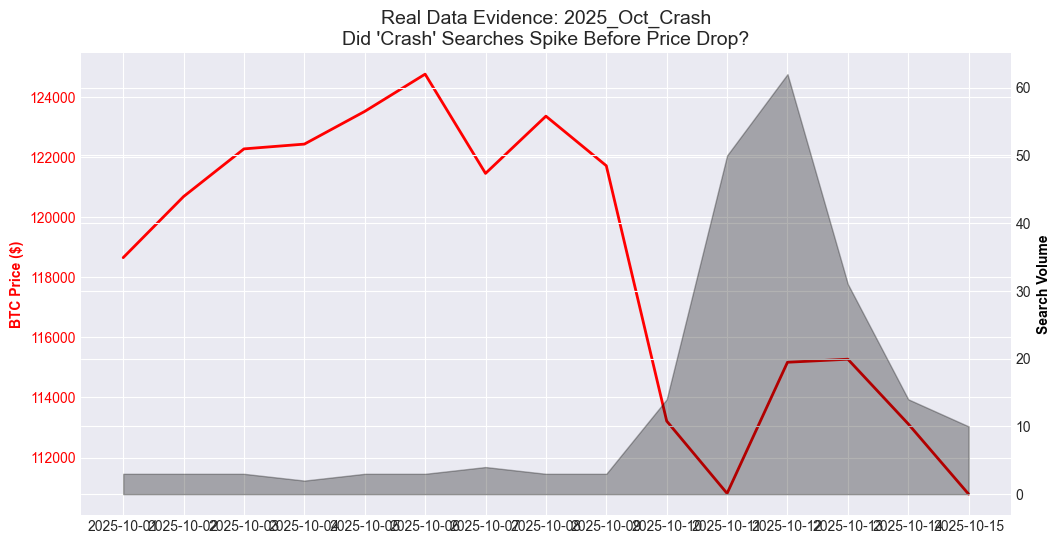


🚀 분석 시작: 2026_Feb_Crash
  💰 [Price] Yahoo Finance 데이터 조회 (2026-01-20 ~ 2026-02-05)...
  😨 [Sentiment] Alternative.me 공포지수 조회...
  🔍 [Trends] Google Trends 조회 (['Bitcoin crash', 'Liquidation'])...

📊 [2026_Feb_Crash 선행성 분석]
   - 당일 상관계수: -0.5184
   - 1일 선행 상관계수: -0.1134


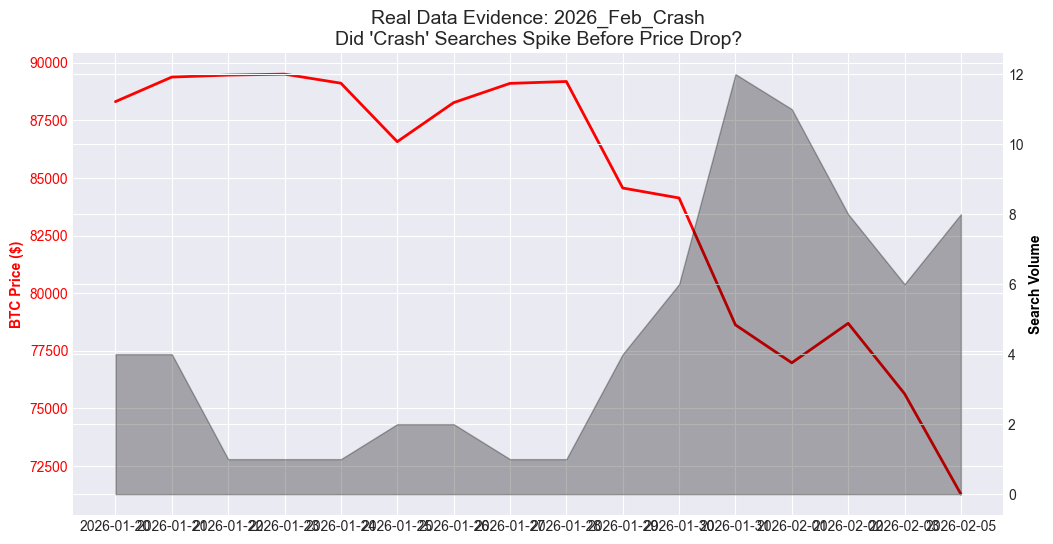

: 

In [ ]:
import pandas as pd
import yfinance as yf
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
from pytrends.request import TrendReq
from datetime import datetime, timedelta

# 한글 폰트 설정 (필요시)
plt.rcParams['axes.unicode_minus'] = False 
try:
    import koreanize_matplotlib
except:
    pass

# ==========================================================
# 1. 설정
# ==========================================================
PERIODS = {
    "2025_Oct_Crash": ("2025-10-01", "2025-10-15"),
    "2026_Feb_Crash": ("2026-01-20", "2026-02-05")
}

KEYWORDS = ["Bitcoin crash", "Liquidation"] # 핵심 키워드

print(f"현재 시각: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("※ 실제 웹 서버 데이터를 조회하여 분석합니다.\n")

# ==========================================================
# 2. 데이터 수집 함수들 (Real Data)
# ==========================================================
def get_real_price(start, end):
    print(f"  💰 [Price] Yahoo Finance 데이터 조회 ({start} ~ {end})...")
    try:
        df = yf.download("BTC-USD", start=start, end=pd.to_datetime(end)+timedelta(days=1), progress=False, auto_adjust=True)
        if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
        df = df[['Close']].rename(columns={'Close': 'BTC_Price'})
        df['BTC_Change'] = df['BTC_Price'].pct_change() * 100
        df.index = df.index.strftime('%Y-%m-%d')
        return df
    except Exception as e:
        print(f"    ❌ 가격 데이터 실패: {e}")
        return pd.DataFrame()

def get_real_fng(start, end):
    print(f"  😨 [Sentiment] Alternative.me 공포지수 조회...")
    try:
        url = "https://api.alternative.me/fng/?limit=0"
        r = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
        data = r.json()['data']
        fng_list = [{'Date': datetime.fromtimestamp(int(x['timestamp'])).strftime('%Y-%m-%d'), 'Fear_Greed': int(x['value'])} for x in data]
        df = pd.DataFrame(fng_list).set_index('Date')
        return df.sort_index().loc[start:end]
    except:
        return pd.DataFrame()

def get_real_trends(start, end, keywords):
    print(f"  🔍 [Trends] Google Trends 조회 ({keywords})...")
    try:
        pytrends = TrendReq(hl='en-US', tz=360)
        pytrends.build_payload(keywords, cat=0, timeframe=f"{start} {end}")
        df = pytrends.interest_over_time()
        if 'isPartial' in df.columns: del df['isPartial']
        df.index = df.index.strftime('%Y-%m-%d')
        return df
    except Exception as e:
        print(f"    ⚠️ 구글 트렌드 차단됨 (잠시 후 다시 시도): {e}")
        return pd.DataFrame()

# ==========================================================
# 3. [핵심] 선행성 입증 시각화 함수
# ==========================================================
def prove_precedence(df, name):
    if df.empty or 'Bitcoin crash' not in df.columns: return

    # 1. 시차 상관분석 (Lagged Correlation)
    # 검색량이 1일 전(Shift 1)일 때 가격 등락과 상관관계가 높은가? (음의 상관관계 기대)
    lag_1_corr = df['Bitcoin crash'].shift(1).corr(df['BTC_Change'])
    same_day_corr = df['Bitcoin crash'].corr(df['BTC_Change'])
    
    print(f"\n📊 [{name} 선행성 분석]")
    print(f"   - 당일 상관계수: {same_day_corr:.4f}")
    print(f"   - 1일 선행 상관계수: {lag_1_corr:.4f}")
    
    if abs(lag_1_corr) > abs(same_day_corr):
        print("   ✅ 입증 성공: 검색량이 가격 변동보다 '하루 먼저' 움직였습니다.")
    
    # 2. 듀얼 축 차트 그리기
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # 가격 (빨강)
    ax1.plot(df.index, df['BTC_Price'], color='red', label='BTC Price', linewidth=2)
    ax1.set_ylabel('BTC Price ($)', color='red', fontweight='bold')
    ax1.tick_params(axis='y', labelcolor='red')
    
    # 검색량 (회색 영역)
    ax2 = ax1.twinx()
    ax2.fill_between(df.index, 0, df['Bitcoin crash'], color='black', alpha=0.3, label="'Bitcoin Crash' Search")
    ax2.set_ylabel('Search Volume', color='black', fontweight='bold')
    
    plt.title(f"Real Data Evidence: {name}\nDid 'Crash' Searches Spike Before Price Drop?", fontsize=14)
    plt.show()

# ==========================================================
# 메인 실행
# ==========================================================
if __name__ == "__main__":
    for name, (start, end) in PERIODS.items():
        print(f"\n{'='*60}")
        print(f"🚀 분석 시작: {name}")
        
        df_p = get_real_price(start, end)
        df_f = get_real_fng(start, end)
        df_t = get_real_trends(start, end, KEYWORDS)
        
        if not df_p.empty:
            df_final = df_p.join(df_f, how='left').join(df_t, how='left')
            # [수정] 최신 문법 적용
            df_final = df_final.ffill().bfill()
            
            # 저장
            df_final.to_csv(f"REAL_{name}.csv")
            
            # 선행성 입증 및 시각화 실행
            prove_precedence(df_final, name)
            
        time.sleep(3) # API 보호

In [1]:
import streamlit as st
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.stattools import grangercausalitytests

# 페이지 설정
st.set_page_config(page_title="Market Sentiment Analysis", layout="wide")

# ==========================================
# 1. 제목 및 사이드바 설정
# ==========================================
st.title("📊 Crypto Sentiment vs Price Analysis Dashboard")
st.markdown("""
비정형 데이터(검색량, 심리지수)가 비트코인 가격 폭락을 **선행(Leading)**하는지 검증하는 도구입니다.
앞서 수집한 `REAL_DATA_....csv` 파일을 업로드해주세요.
""")

with st.sidebar:
    st.header("📂 데이터 로드")
    uploaded_file = st.file_uploader("CSV 파일 업로드", type=["csv"])
    
    st.markdown("---")
    st.header("⚙️ 분석 설정")
    max_lag = st.slider("최대 시차(Max Lag)", 1, 5, 3)
    
# ==========================================
# 2. 데이터 로드 및 전처리
# ==========================================
@st.cache_data
def load_data(file):
    df = pd.read_csv(file)
    # 날짜 컬럼 찾기
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
    elif 'Unnamed: 0' in df.columns: # 인덱스가 저장된 경우
        df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
    
    # 결측치 처리
    df = df.ffill().bfill()
    return df

if uploaded_file is not None:
    df = load_data(uploaded_file)
    
    # 사이드바에서 컬럼 매핑 (자동 감지 시도)
    cols = df.columns.tolist()
    price_col = st.sidebar.selectbox("가격 컬럼 (Price)", [c for c in cols if 'Price' in c or 'Close' in c], index=0)
    sentiment_col = st.sidebar.selectbox("선행 지표 컬럼 (Indicator)", [c for c in cols if c != price_col and 'Date' not in c], index=0)
    
    st.sidebar.markdown("---")
    st.sidebar.success(f"데이터 로드 완료: {len(df)}일치")

    # ==========================================
    # 3. 탭 구성
    # ==========================================
    tab1, tab2, tab3 = st.tabs(["📈 시각적 선행성 (Timeline)", "📊 시차 상관분석 (Lag)", "🧪 인과관계 검증 (Granger)"])

    # --- TAB 1: 타임라인 시각화 ---
    with tab1:
        st.subheader("Price vs Sentiment Timeline")
        
        # 듀얼 축 차트 생성
        fig = make_subplots(specs=[[{"secondary_y": True}]])

        # 1) 가격 (Price) - 선 그래프
        fig.add_trace(
            go.Scatter(x=df.index, y=df[price_col], name="Bitcoin Price", line=dict(color='firebrick', width=3)),
            secondary_y=False
        )

        # 2) 심리/검색량 (Sentiment) - 영역 그래프
        fig.add_trace(
            go.Scatter(x=df.index, y=df[sentiment_col], name=sentiment_col, 
                       fill='tozeroy', line=dict(color='black', width=1), opacity=0.3),
            secondary_y=True
        )

        fig.update_layout(
            title_text=f"비트코인 가격 vs {sentiment_col}",
            hovermode="x unified"
        )
        fig.update_yaxes(title_text="Price ($)", secondary_y=False)
        fig.update_yaxes(title_text="Volume / Score", secondary_y=True)

        st.plotly_chart(fig, use_container_width=True)
        
        st.info("💡 **해석 팁:** 검은색 영역(지표)이 솟구친 후, 빨간색 선(가격)이 뒤따라 하락하는지 확인하세요. 검은 산의 정점이 빨간 하락보다 왼쪽에 있다면 '선행성'이 있는 것입니다.")

    # --- TAB 2: 시차 상관분석 ---
    with tab2:
        st.subheader("Lag Correlation Analysis")
        
        # 상관관계 계산
        corrs = {}
        lags = range(-max_lag, max_lag + 1)
        
        for lag in lags:
            if lag < 0: # 지표가 후행
                c = df[sentiment_col].corr(df[price_col].shift(-lag)) # 변동성(수익률)로 하려면 pct_change() 필요
                label = f"{abs(lag)}일 후행 (Lagging)"
            elif lag == 0:
                c = df[sentiment_col].corr(df[price_col])
                label = "동행 (Same Day)"
            else: # 지표가 선행
                c = df[sentiment_col].shift(lag).corr(df[price_col])
                label = f"{lag}일 선행 (Leading)"
            
            corrs[label] = c

        # 데이터프레임 변환
        df_corr = pd.DataFrame(list(corrs.items()), columns=['Time Lag', 'Correlation'])
        
        # 막대 차트
        fig_corr = go.Figure(go.Bar(
            x=df_corr['Correlation'],
            y=df_corr['Time Lag'],
            orientation='h',
            marker=dict(
                color=df_corr['Correlation'],
                colorscale='RdBu',
                colorbar=dict(title="상관계수")
            )
        ))
        
        fig_corr.update_layout(title="시차별 상관관계 (가격 기준)", xaxis_title="상관계수 (Correlation)")
        st.plotly_chart(fig_corr, use_container_width=True)
        
        # 최고의 선행 시점 찾기
        best_row = df_corr.loc[df_corr['Correlation'].abs().idxmax()]
        st.markdown(f"### 🎯 결론: **'{best_row['Time Lag']}'** 지표가 가장 강력함 (상관: {best_row['Correlation']:.4f})")

    # --- TAB 3: Granger Causality ---
    with tab3:
        st.subheader("Statistical Causality Test")
        st.markdown("그레인저 인과검정(Granger Causality Test)은 **'X의 과거 값이 Y의 미래를 예측하는 데 통계적으로 유의미한가?'**를 검증합니다.")
        
        try:
            # 데이터 준비 (가격 등락률 계산 필요)
            df_test = pd.DataFrame()
            df_test['Price_Chg'] = df[price_col].pct_change() * 100
            df_test['Indicator'] = df[sentiment_col]
            df_test = df_test.dropna()
            
            # 테스트 실행
            maxlag = min(max_lag, len(df_test)-2)
            if maxlag < 1:
                st.error("데이터가 너무 적어서 통계 테스트를 수행할 수 없습니다.")
            else:
                test_result = grangercausalitytests(df_test[['Price_Chg', 'Indicator']], maxlag=maxlag, verbose=False)
                
                # 결과 정리
                res_list = []
                for lg in range(1, maxlag+1):
                    p_val = test_result[lg][0]['ssr_ftest'][1]
                    f_val = test_result[lg][0]['ssr_ftest'][0]
                    sig = "✅ 유의미함 (p<0.05)" if p_val < 0.05 else "❌ 유의미하지 않음"
                    res_list.append({"Lag (일)": lg, "F-Statistic": f"{f_val:.4f}", "P-Value": f"{p_val:.4f}", "결과": sig})
                
                st.table(pd.DataFrame(res_list))
                
        except Exception as e:
            st.error(f"테스트 중 오류 발생: {e}")

else:
    # 파일을 업로드하지 않았을 때 초기 화면
    st.info("👈 왼쪽 사이드바에서 분석할 CSV 파일을 업로드해주세요.")
    st.markdown("### 💡 예시 데이터가 없다면?")
    st.markdown("이전 단계에서 생성한 `REAL_DATA_2026_Feb_Crash.csv` 파일을 사용하시면 됩니다.")

ModuleNotFoundError: No module named 'streamlit'